In [82]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']
animals = np.concatenate((dualanimalnames,danimals))

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

current_version = 0 #July 13th 2023

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

In [4]:
pre_FR_baseline = []
post_FR_baseline = []

pre_FR_mod = []
post_FR_mod = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task != 'switch':
        continue
    if sessionfile.meta.animal not in animals:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    for clust in sessionfile.clusters.good:
        pre_bl = sessionfile.responsiveness[clust]['pre_switch'].FRbaseline
        post_bl = sessionfile.responsiveness[clust]['post_switch'].FRbaseline
        pre_FRm = sessionfile.responsiveness[clust]['pre_switch'].FRmodulation
        post_FRm = sessionfile.responsiveness[clust]['post_switch'].FRmodulation
#         pre_FRr = sessionfile.responsiveness[clust]['pre_switch_go'].rampingMod
#         post_FRr = sessionfile.responsiveness[clust]['post_switch_go'].rampingMod
        pre_FR_baseline.append(pre_bl)
        post_FR_baseline.append(post_bl)
        pre_FR_mod.append(pre_FRm)
        post_FR_mod.append(post_FRm)
#         pre_FR_ramp.append(pre_FRr)
#         post_FR_ramp.append(post_FRr)

100%|██████████| 661/661 [00:08<00:00, 78.55it/s] 


In [16]:
# pre_FR_baseline = []
# post_FR_baseline = []

# pre_FR_mod = []
# post_FR_mod = []

pre_FR_ramp = []
post_FR_ramp = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task != 'switch':
        continue
    if sessionfile.meta.animal not in animals:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    for clust in sessionfile.clusters.good:
        
#         rampingMod = sessionfile.responsiveness[clust]['pre_switch_go'].rampingMod
#         if rampingMod <= 0:
#             continue
#         rampingMod = sessionfile.responsiveness[clust]['post_switch_go'].rampingMod
#         if rampingMod <= 0:
#             continue
        rampingMod = sessionfile.responsiveness[clust]['go'].rampingMod
        if rampingMod <= 0:
            continue
            
#         pre_bl = sessionfile.responsiveness[clust]['pre_switch'].FRbaseline
#         post_bl = sessionfile.responsiveness[clust]['post_switch'].FRbaseline
#         pre_FRm = sessionfile.responsiveness[clust]['pre_switch'].FRmodulation
#         post_FRm = sessionfile.responsiveness[clust]['post_switch'].FRmodulation
        pre_FRr = sessionfile.responsiveness[clust]['pre_switch_go'].rampingMod
        post_FRr = sessionfile.responsiveness[clust]['post_switch_go'].rampingMod
#         pre_FR_baseline.append(pre_bl)
#         post_FR_baseline.append(post_bl)
#         pre_FR_mod.append(pre_FRm)
#         post_FR_mod.append(post_FRm)
        pre_FR_ramp.append(pre_FRr)
        post_FR_ramp.append(post_FRr)

100%|██████████| 661/661 [00:06<00:00, 109.75it/s]


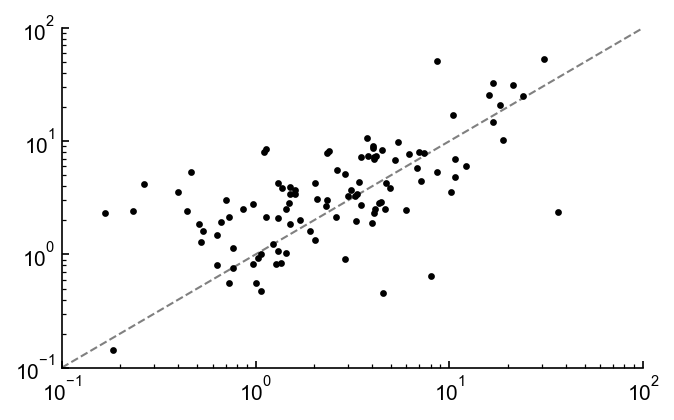

In [3]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(pre_FR_baseline,post_FR_baseline,s=5,c='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1,100])
ax.set_ylim([0.1,100])
ax.plot([0.1,100],[0.1,100],color='grey',lw=1,linestyle='--',zorder=-10)

# Baseline

Wilcoxon p = 0.025542788961259687
Mann-whitney p = 0.2658846022734138


<ipython-input-5-3d9409167137>:8: RuntimeWarning: divide by zero encountered in log10
  X_plot,_ = ilep.violin(X_plot,np.log10(column),width=0.5)


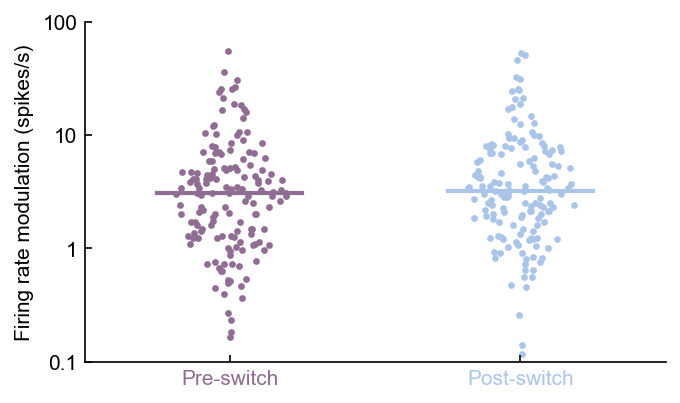

In [5]:
fig, ax = plt.subplots(figsize=(5,3))

data = ilep.paired_rmnan(pre_FR_baseline,post_FR_baseline)
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

for idx,(X_plot,column) in enumerate(zip(X,data)):
    _,Y = ilep.violin(X_plot,column,width=0.5)
    X_plot,_ = ilep.violin(X_plot,np.log10(column),width=0.5)

    ax.scatter(X_plot,Y,s=5,c=PHASE_COLORS[idx+2])
    ax.set_yscale('log',subs=[])
    ax.set_ylim([0.1,100])

    ax.set_xlim([-0.5,1.5])
    
ax.set_xticks([0,1])
ax.set_xticklabels(['Pre-switch','Post-switch'])

ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels([0.1,1,10,100])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_ylabel('Firing rate modulation (spikes/s)')

pre_median = np.nanmedian(data[0])
post_median = np.nanmedian(data[1])
ax.plot([-0.25,0.25],[pre_median]*2,color=PHASE_COLORS[2],lw=2)
ax.plot([1-0.25,1.25],[post_median]*2,color=PHASE_COLORS[3],lw=2)

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Pre-post baseline.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Pre-post baseline.png'),transparent=False,facecolor="white")

# Modulation

Wilcoxon p = 0.2396822211829155
Mann-whitney p = 0.37746634464676876


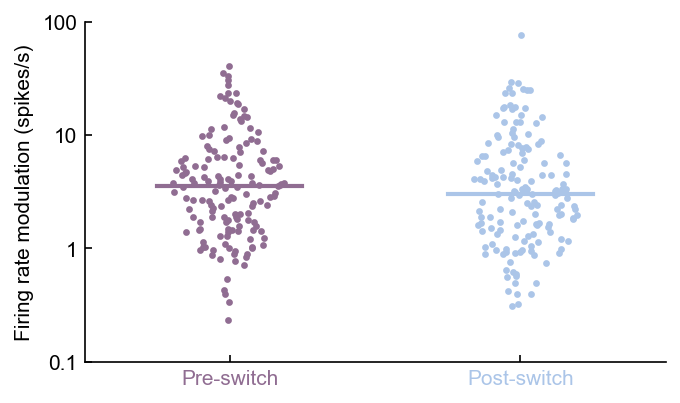

In [6]:
fig, ax = plt.subplots(figsize=(5,3))

data = ilep.paired_rmnan(pre_FR_mod,post_FR_mod)
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

for idx,(X_plot,column) in enumerate(zip(X,data)):
    _,Y = ilep.violin(X_plot,column,width=0.5)
    X_plot,_ = ilep.violin(X_plot,np.log10(column),width=0.5)

    ax.scatter(X_plot,Y,s=5,c=PHASE_COLORS[idx+2])
    ax.set_yscale('log',subs=[])
    ax.set_ylim([0.1,100])

    ax.set_xlim([-0.5,1.5])
    
ax.set_xticks([0,1])
ax.set_xticklabels(['Pre-switch','Post-switch'])

ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels([0.1,1,10,100])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_ylabel('Firing rate modulation (spikes/s)')

pre_median = np.nanmedian(data[0])
post_median = np.nanmedian(data[1])
ax.plot([-0.25,0.25],[pre_median]*2,color=PHASE_COLORS[2],lw=2)
ax.plot([1-0.25,1.25],[post_median]*2,color=PHASE_COLORS[3],lw=2)

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Pre-post stimulus.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Pre-post stimulus.png'),transparent=False,facecolor="white")

# Ramping

Wilcoxon p = 0.09680291046914201
Mann-whitney p = 0.1665905906992302


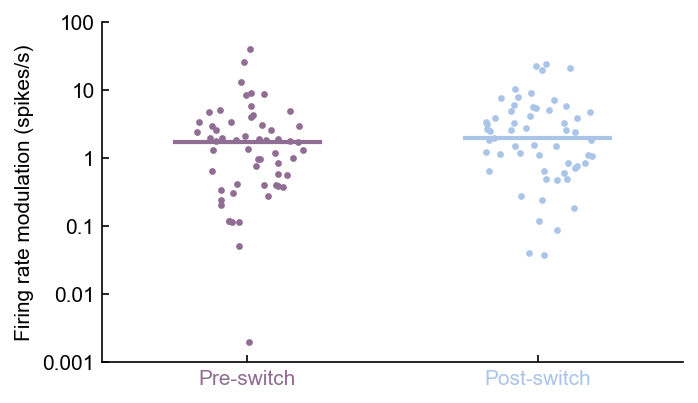

In [17]:
fig, ax = plt.subplots(figsize=(5,3))

data = ilep.paired_rmnan(np.abs(pre_FR_ramp),np.abs(post_FR_ramp),positiveOnly=True)
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

for idx,(X_plot,column) in enumerate(zip(X,data)):
    _,Y = ilep.violin(X_plot,column,width=0.5)
    X_plot,_ = ilep.violin(X_plot,np.log10(column),width=0.5)

    ax.scatter(X_plot,Y,s=5,c=PHASE_COLORS[idx+2])
    ax.set_yscale('log',subs=[])
    ax.set_ylim([0.1,100])

    ax.set_xlim([-0.5,1.5])
    
ax.set_xticks([0,1])
ax.set_xticklabels(['Pre-switch','Post-switch'])

ax.set_yticks([0.001,0.01,0.1,1,10,100])
ax.set_yticklabels([0.001,0.01,0.1,1,10,100])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_ylabel('Firing rate modulation (spikes/s)')

pre_median = np.nanmedian(data[0])
post_median = np.nanmedian(data[1])
ax.plot([-0.25,0.25],[pre_median]*2,color=PHASE_COLORS[2],lw=2)
ax.plot([1-0.25,1.25],[post_median]*2,color=PHASE_COLORS[3],lw=2)

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Pre-post ramping.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Pre-post ramping.png'),transparent=False,facecolor="white")

In [19]:
np.mean(np.greater(pre_FR_ramp,0))

0.6753246753246753

In [20]:
np.mean(np.greater(post_FR_ramp,0))

0.6623376623376623

# Modulation

Wilcoxon p = 0.7545507623415532
Mann-whitney p = 0.9713405163089538


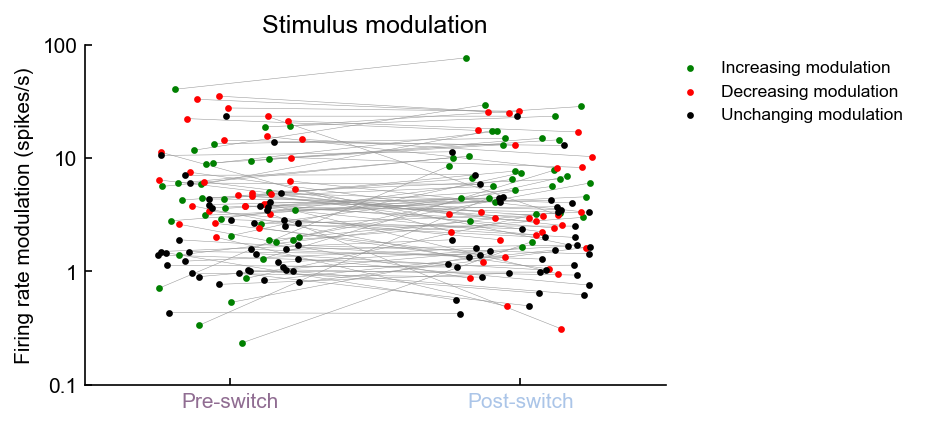

In [7]:
fig, ax = plt.subplots(figsize=(5,3))

data = ilep.paired_rmnan(pre_FR_mod,post_FR_mod)
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

X_plot = np.random.uniform(-0.25,0.25,size=len(data[0]))
for idx,(X_offset,column) in enumerate(zip(X,data)):
    Y_values = column
    X_values = X_plot+X_offset
    #ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c=PHASE_COLORS[idx+2])
    ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c='green')
    ax.scatter(X_values[decrease_mask],Y_values[decrease_mask],s=5,c='red')
    ax.scatter(X_values[unchange_mask],Y_values[unchange_mask],s=5,c='k')
    ax.set_yscale('log',subs=[])
    ax.set_ylim([0.1,100])

    ax.set_xlim([-0.5,1.5])
    
ax.plot([X_plot,X_plot+1],data,lw=0.25,zorder=-20,color=GOOD_GREY)
    
ax.set_xticks([0,1])
ax.set_xticklabels(['Pre-switch','Post-switch'])
fig, ax = plt.subplots(figsize=(5,3))

data = ilep.paired_rmnan(pre_FR_mod,post_FR_mod)
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

X_plot = np.random.uniform(-0.25,0.25,size=len(data[0]))
for idx,(X_offset,column) in enumerate(zip(X,data)):
    Y_values = column
    X_values = X_plot+X_offset
    #ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c=PHASE_COLORS[idx+2])
    ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c='green')
    ax.scatter(X_values[decrease_mask],Y_values[decrease_mask],s=5,c='red')
    ax.scatter(X_values[unchange_mask],Y_values[unchange_mask],s=5,c='k')
    ax.set_yscale('log',subs=[])
    ax.set_ylim([0.1,100])

    ax.set_xlim([-0.5,1.5])
    
ax.plot([X_plot,X_plot+1],data,lw=0.25,zorder=-20,color=GOOD_GREY)
    
ax.set_xticks([0,1])
ax.set_xticklabels(['Pre-switch','Post-switch'])

ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels([0.1,1,10,100])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.scatter([],[],s=5,c='green',label='Increasing modulation')
ax.scatter([],[],s=5,c='red',label='Decreasing modulation')
ax.scatter([],[],s=5,c='k',label='Unchanging modulation')
lgd = ax.legend(frameon=False,loc=(1,0.75))

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")

ax.set_title('Stimulus modulation')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus switch modulation.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus switch modulation.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels([0.1,1,10,100])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.scatter([],[],s=5,c='green',label='Increasing modulation')
ax.scatter([],[],s=5,c='red',label='Decreasing modulation')
ax.scatter([],[],s=5,c='k',label='Unchanging modulation')
lgd = ax.legend(frameon=False,loc=(1,0.75))

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")

ax.set_title('Stimulus modulation')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus switch modulation.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus switch modulation.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Ramping

Wilcoxon p = 0.051304111871166805
Mann-whitney p = 0.39073207043595504


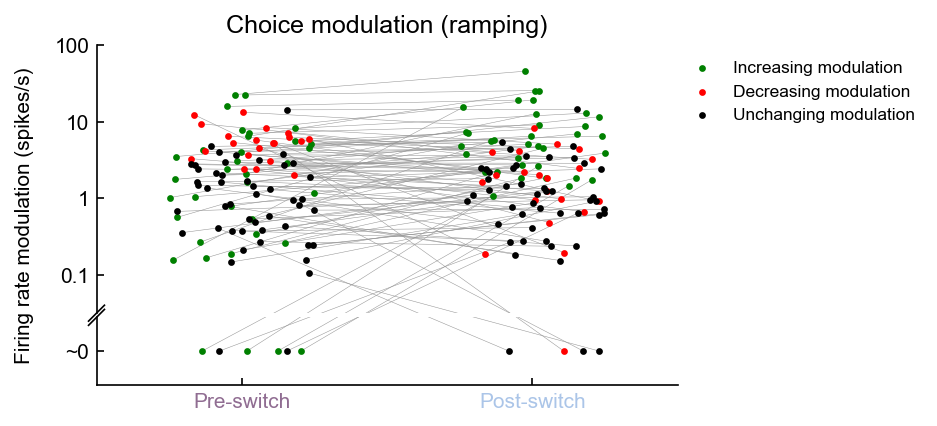

In [8]:
fig = plt.figure(figsize=(5, 3))
bax = brokenaxes(ylims=( (0.01/2.75,0.01*2.75), (0.03162277660168379, 100) ), hspace=0.025, yscale='log')

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_FR_ramp),np.abs(post_FR_ramp),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

X_plot = np.random.uniform(-0.25,0.25,size=len(data[0]))
for idx,(X_offset,column) in enumerate(zip(X,data)):
    Y_values = column
    X_values = X_plot+X_offset
    #ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c=PHASE_COLORS[idx+2])
    bax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c='green')
    bax.scatter(X_values[decrease_mask],Y_values[decrease_mask],s=5,c='red')
    bax.scatter(X_values[unchange_mask],Y_values[unchange_mask],s=5,c='k')
    
bax.plot([X_plot,X_plot+1],[data[0],data[1]],lw=0.25,zorder=-20,color=GOOD_GREY)

#############################################################################################

bax.scatter([],[],s=5,c='green',label='Increasing modulation')
bax.scatter([],[],s=5,c='red',label='Decreasing modulation')
bax.scatter([],[],s=5,c='k',label='Unchanging modulation')
lgd = bax.legend(frameon=False,loc=(1,0.75))

bax.set_ylabel('Firing rate modulation (spikes/s)')

bax.set_xlim([-0.5,1.5])
bax.axs[1].set_xticks([0,1])
bax.axs[1].set_xticklabels(['Pre-switch','Post-switch'])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(bax.axs[1].xaxis.get_ticklabels())]

for ax in bax.axs:
    ax.set_yscale('log',subs=[])
bax.axs[0].set_yticks([0.1,1,10,100])
bax.axs[0].set_yticklabels(['0.1','1','10','100'])
bax.axs[0].spines['bottom'].set_visible(False)
bax.axs[0].get_xaxis().set_visible(False)
bax.axs[1].set_yticks([0.01])
bax.axs[1].set_yticklabels(['~0'])

bax.set_title('Choice modulation (ramping)')

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")

fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice switch modulation.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice switch modulation.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Modulation pre-post. Separated by tone

In [9]:
pre_FR_mod_t = []
post_FR_mod_t = []
pre_FR_mod_nt = []
post_FR_mod_nt = []

pre_ramp_t = []
post_ramp_t = []
pre_ramp_nt = []
post_ramp_nt = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task != 'switch':
        continue
    if sessionfile.meta.animal not in animals:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    for clust in sessionfile.clusters.good:
        pre_FRm_t = sessionfile.responsiveness[clust]['pre_switch_target'].FRmodulation
        post_FRm_t = sessionfile.responsiveness[clust]['post_switch_target'].FRmodulation
        pre_FRm_nt = sessionfile.responsiveness[clust]['pre_switch_nontarget'].FRmodulation
        post_FRm_nt = sessionfile.responsiveness[clust]['post_switch_nontarget'].FRmodulation
        
        pre_rmp_t = sessionfile.responsiveness[clust]['pre_switch_hit'].rampingMod
        post_rmp_t = sessionfile.responsiveness[clust]['post_switch_hit'].rampingMod
        pre_rmp_nt = sessionfile.responsiveness[clust]['pre_switch_falarm'].rampingMod
        post_rmp_nt = sessionfile.responsiveness[clust]['post_switch_falarm'].rampingMod
        
        pre_FR_mod_t.append(pre_FRm_t)
        post_FR_mod_t.append(post_FRm_t)
        pre_FR_mod_nt.append(pre_FRm_nt)
        post_FR_mod_nt.append(post_FRm_nt)
        
        pre_ramp_t.append(pre_rmp_t)
        post_ramp_t.append(post_rmp_t)
        pre_ramp_nt.append(pre_rmp_nt)
        post_ramp_nt.append(post_rmp_nt)

100%|██████████| 592/592 [00:02<00:00, 199.63it/s]


Wilcoxon p = 0.06441928663285888
Mann-whitney p = 0.4922897152622321


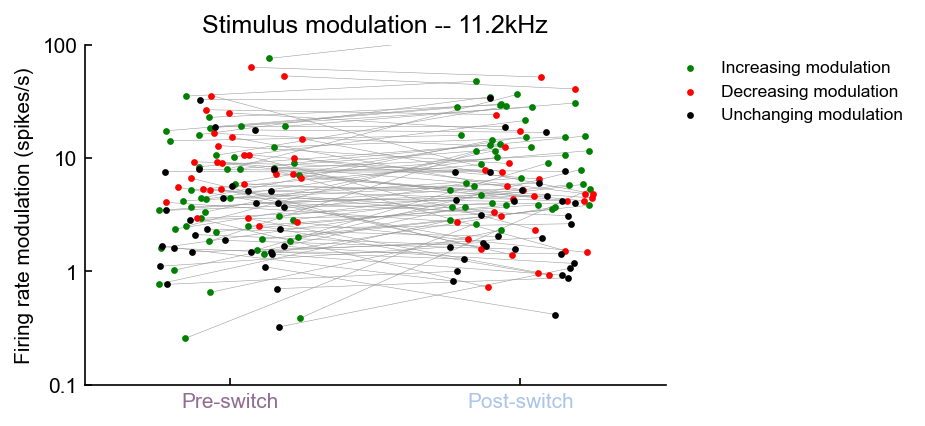

In [10]:
fig, ax = plt.subplots(figsize=(5,3))

data = ilep.paired_rmnan(pre_FR_mod_t,post_FR_mod_nt,positiveOnly=True)
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

X_plot = np.random.uniform(-0.25,0.25,size=len(data[0]))
for idx,(X_offset,column) in enumerate(zip(X,data)):
    Y_values = column
    X_values = X_plot+X_offset
    #ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c=PHASE_COLORS[idx+2])
    ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c='green')
    ax.scatter(X_values[decrease_mask],Y_values[decrease_mask],s=5,c='red')
    ax.scatter(X_values[unchange_mask],Y_values[unchange_mask],s=5,c='k')
    ax.set_yscale('log',subs=[])
    ax.set_ylim([0.1,100])

    ax.set_xlim([-0.5,1.5])
    
ax.plot([X_plot,X_plot+1],data,lw=0.25,zorder=-20,color=GOOD_GREY)
    
ax.set_xticks([0,1])
ax.set_xticklabels(['Pre-switch','Post-switch'])

ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels([0.1,1,10,100])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.scatter([],[],s=5,c='green',label='Increasing modulation')
ax.scatter([],[],s=5,c='red',label='Decreasing modulation')
ax.scatter([],[],s=5,c='k',label='Unchanging modulation')
lgd = ax.legend(frameon=False,loc=(1,0.75))

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")

ax.set_title('Stimulus modulation -- 11.2kHz')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus switch modulation 11k.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus switch modulation 11k.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

Wilcoxon p = 0.8253503108785785
Mann-whitney p = 0.8780417663321266


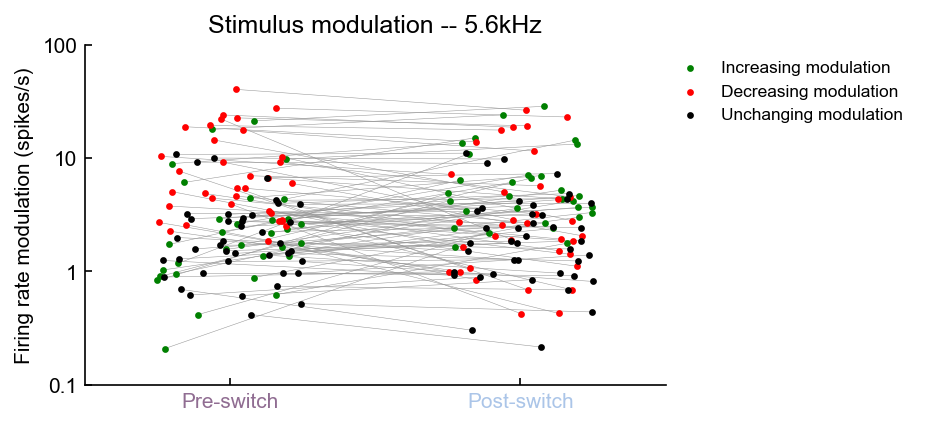

In [11]:
fig, ax = plt.subplots(figsize=(5,3))

data = ilep.paired_rmnan(pre_FR_mod_nt,post_FR_mod_t,positiveOnly=True)
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

X_plot = np.random.uniform(-0.25,0.25,size=len(data[0]))
for idx,(X_offset,column) in enumerate(zip(X,data)):
    Y_values = column
    X_values = X_plot+X_offset
    #ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c=PHASE_COLORS[idx+2])
    ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c='green')
    ax.scatter(X_values[decrease_mask],Y_values[decrease_mask],s=5,c='red')
    ax.scatter(X_values[unchange_mask],Y_values[unchange_mask],s=5,c='k')
    ax.set_yscale('log',subs=[])
    ax.set_ylim([0.1,100])

    ax.set_xlim([-0.5,1.5])
    
ax.plot([X_plot,X_plot+1],data,lw=0.25,zorder=-20,color=GOOD_GREY)
    
ax.set_xticks([0,1])
ax.set_xticklabels(['Pre-switch','Post-switch'])

ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels([0.1,1,10,100])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.scatter([],[],s=5,c='green',label='Increasing modulation')
ax.scatter([],[],s=5,c='red',label='Decreasing modulation')
ax.scatter([],[],s=5,c='k',label='Unchanging modulation')
lgd = ax.legend(frameon=False,loc=(1,0.75))

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")

ax.set_title('Stimulus modulation -- 5.6kHz')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus switch modulation 5k.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus switch modulation 5k.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

Wilcoxon p = 2.6453017494562133e-05
Mann-whitney p = 0.0007811399134687824


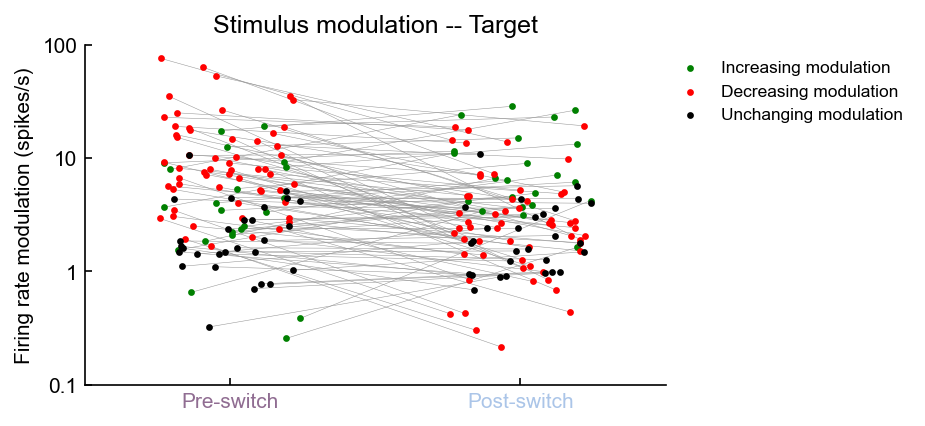

In [12]:
fig, ax = plt.subplots(figsize=(5,3))

data = ilep.paired_rmnan(pre_FR_mod_t,post_FR_mod_t,positiveOnly=True)
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

X_plot = np.random.uniform(-0.25,0.25,size=len(data[0]))
for idx,(X_offset,column) in enumerate(zip(X,data)):
    Y_values = column
    X_values = X_plot+X_offset
    #ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c=PHASE_COLORS[idx+2])
    ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c='green')
    ax.scatter(X_values[decrease_mask],Y_values[decrease_mask],s=5,c='red')
    ax.scatter(X_values[unchange_mask],Y_values[unchange_mask],s=5,c='k')
    ax.set_yscale('log',subs=[])
    ax.set_ylim([0.1,100])

    ax.set_xlim([-0.5,1.5])
    
ax.plot([X_plot,X_plot+1],data,lw=0.25,zorder=-20,color=GOOD_GREY)
    
ax.set_xticks([0,1])
ax.set_xticklabels(['Pre-switch','Post-switch'])

ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels([0.1,1,10,100])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.scatter([],[],s=5,c='green',label='Increasing modulation')
ax.scatter([],[],s=5,c='red',label='Decreasing modulation')
ax.scatter([],[],s=5,c='k',label='Unchanging modulation')
lgd = ax.legend(frameon=False,loc=(1,0.75))

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")

ax.set_title('Stimulus modulation -- Target')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus switch modulation target.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus switch modulation target.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

Wilcoxon p = 1.5476244290796971e-06
Mann-whitney p = 5.434242313884824e-05


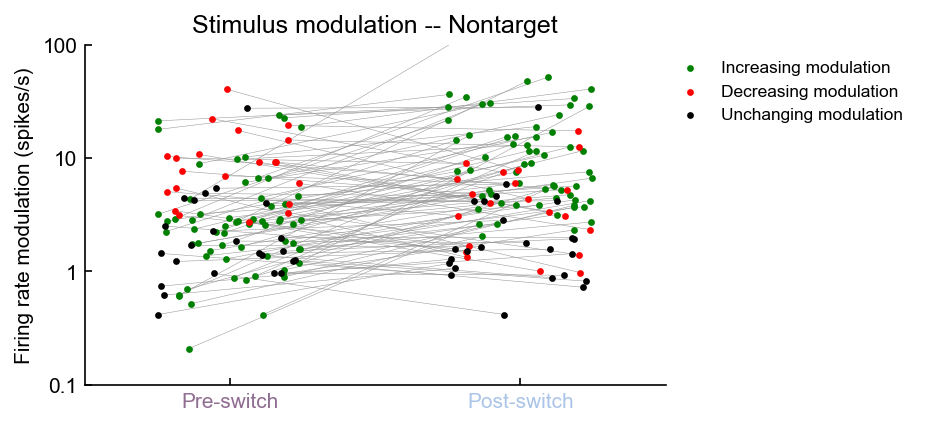

In [13]:
fig, ax = plt.subplots(figsize=(5,3))

data = ilep.paired_rmnan(pre_FR_mod_nt,post_FR_mod_nt,positiveOnly=True)
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

X_plot = np.random.uniform(-0.25,0.25,size=len(data[0]))
for idx,(X_offset,column) in enumerate(zip(X,data)):
    Y_values = column
    X_values = X_plot+X_offset
    #ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c=PHASE_COLORS[idx+2])
    ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c='green')
    ax.scatter(X_values[decrease_mask],Y_values[decrease_mask],s=5,c='red')
    ax.scatter(X_values[unchange_mask],Y_values[unchange_mask],s=5,c='k')
    ax.set_yscale('log',subs=[])
    ax.set_ylim([0.1,100])

    ax.set_xlim([-0.5,1.5])
    
ax.plot([X_plot,X_plot+1],data,lw=0.25,zorder=-20,color=GOOD_GREY)
    
ax.set_xticks([0,1])
ax.set_xticklabels(['Pre-switch','Post-switch'])

ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels([0.1,1,10,100])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.scatter([],[],s=5,c='green',label='Increasing modulation')
ax.scatter([],[],s=5,c='red',label='Decreasing modulation')
ax.scatter([],[],s=5,c='k',label='Unchanging modulation')
lgd = ax.legend(frameon=False,loc=(1,0.75))

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")

ax.set_title('Stimulus modulation -- Nontarget')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus switch modulation nontarget.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus switch modulation nontarget.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Ramping pre-post. Separated by tone

Wilcoxon p = 0.14871185095600323
Mann-whitney p = 0.6224482719353254


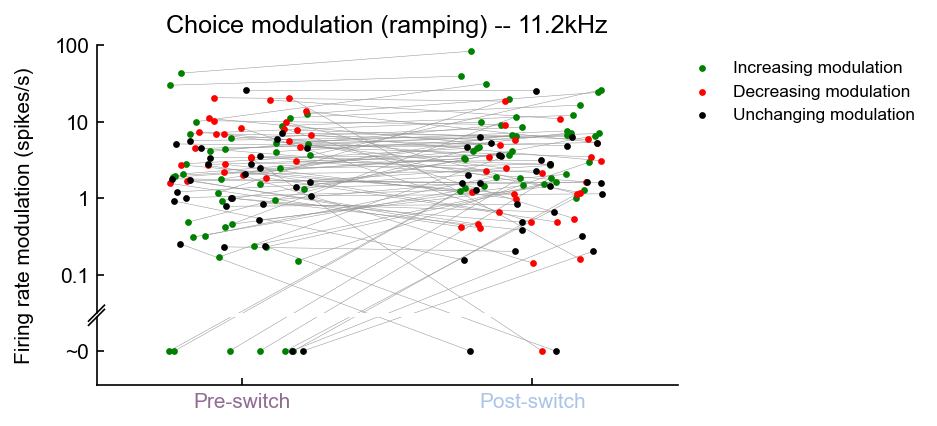

In [14]:
fig = plt.figure(figsize=(5, 3))
bax = brokenaxes(ylims=( (0.01/2.75,0.01*2.75), (0.03162277660168379, 100) ), hspace=0.025, yscale='log')

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_ramp_t),np.abs(post_ramp_nt),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

X_plot = np.random.uniform(-0.25,0.25,size=len(data[0]))
for idx,(X_offset,column) in enumerate(zip(X,data)):
    Y_values = column
    X_values = X_plot+X_offset
    #ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c=PHASE_COLORS[idx+2])
    bax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c='green')
    bax.scatter(X_values[decrease_mask],Y_values[decrease_mask],s=5,c='red')
    bax.scatter(X_values[unchange_mask],Y_values[unchange_mask],s=5,c='k')
    
bax.plot([X_plot,X_plot+1],[data[0],data[1]],lw=0.25,zorder=-20,color=GOOD_GREY)

#############################################################################################

bax.scatter([],[],s=5,c='green',label='Increasing modulation')
bax.scatter([],[],s=5,c='red',label='Decreasing modulation')
bax.scatter([],[],s=5,c='k',label='Unchanging modulation')
lgd = bax.legend(frameon=False,loc=(1,0.75))

bax.set_ylabel('Firing rate modulation (spikes/s)')

bax.set_xlim([-0.5,1.5])
bax.axs[1].set_xticks([0,1])
bax.axs[1].set_xticklabels(['Pre-switch','Post-switch'])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(bax.axs[1].xaxis.get_ticklabels())]

for ax in bax.axs:
    ax.set_yscale('log',subs=[])
bax.axs[0].set_yticks([0.1,1,10,100])
bax.axs[0].set_yticklabels(['0.1','1','10','100'])
bax.axs[0].spines['bottom'].set_visible(False)
bax.axs[0].get_xaxis().set_visible(False)
\
bax.axs[1].set_yticks([0.01])
bax.axs[1].set_yticklabels(['~0'])

bax.set_title('Choice modulation (ramping) -- 11.2kHz')

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")

fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice switch modulation -- 11khz.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice switch modulation -- 11khz.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

Wilcoxon p = 0.011842020602936116
Mann-whitney p = 0.0265005837386324


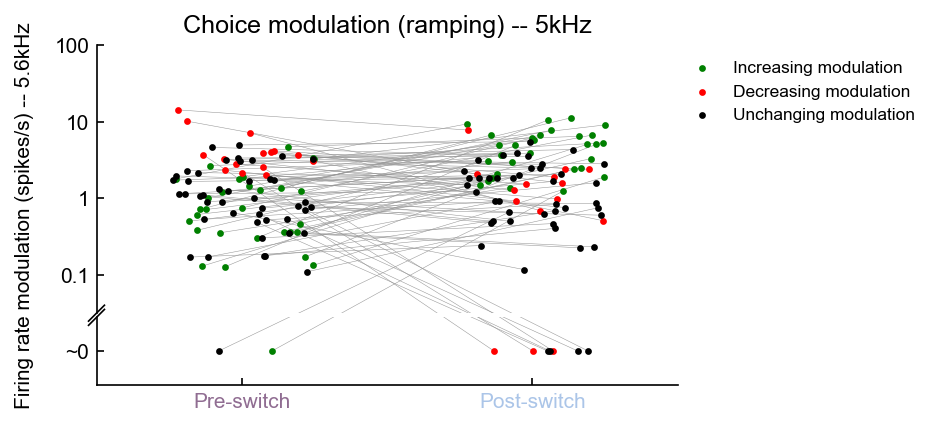

In [15]:
fig = plt.figure(figsize=(5, 3))
bax = brokenaxes(ylims=( (0.01/2.75,0.01*2.75), (0.03162277660168379, 100) ), hspace=0.025, yscale='log')

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_ramp_nt),np.abs(post_ramp_t),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

X_plot = np.random.uniform(-0.25,0.25,size=len(data[0]))
for idx,(X_offset,column) in enumerate(zip(X,data)):
    Y_values = column
    X_values = X_plot+X_offset
    #ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c=PHASE_COLORS[idx+2])
    bax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c='green')
    bax.scatter(X_values[decrease_mask],Y_values[decrease_mask],s=5,c='red')
    bax.scatter(X_values[unchange_mask],Y_values[unchange_mask],s=5,c='k')
    
bax.plot([X_plot,X_plot+1],[data[0],data[1]],lw=0.25,zorder=-20,color=GOOD_GREY)

#############################################################################################

bax.scatter([],[],s=5,c='green',label='Increasing modulation')
bax.scatter([],[],s=5,c='red',label='Decreasing modulation')
bax.scatter([],[],s=5,c='k',label='Unchanging modulation')
lgd = bax.legend(frameon=False,loc=(1,0.75))

bax.set_ylabel('Firing rate modulation (spikes/s) -- 5.6kHz')

bax.set_xlim([-0.5,1.5])
bax.axs[1].set_xticks([0,1])
bax.axs[1].set_xticklabels(['Pre-switch','Post-switch'])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(bax.axs[1].xaxis.get_ticklabels())]

for ax in bax.axs:
    ax.set_yscale('log',subs=[])
bax.axs[0].set_yticks([0.1,1,10,100])
bax.axs[0].set_yticklabels(['0.1','1','10','100'])
bax.axs[0].spines['bottom'].set_visible(False)
bax.axs[0].get_xaxis().set_visible(False)
bax.axs[1].set_yticks([0.01])
bax.axs[1].set_yticklabels(['~0'])

bax.set_title('Choice modulation (ramping) -- 5kHz')

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")

fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice switch modulation -- 5kHz.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice switch modulation -- 5kHz.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

Wilcoxon p = 0.0077899328209697985
Mann-whitney p = 0.08266967938053063


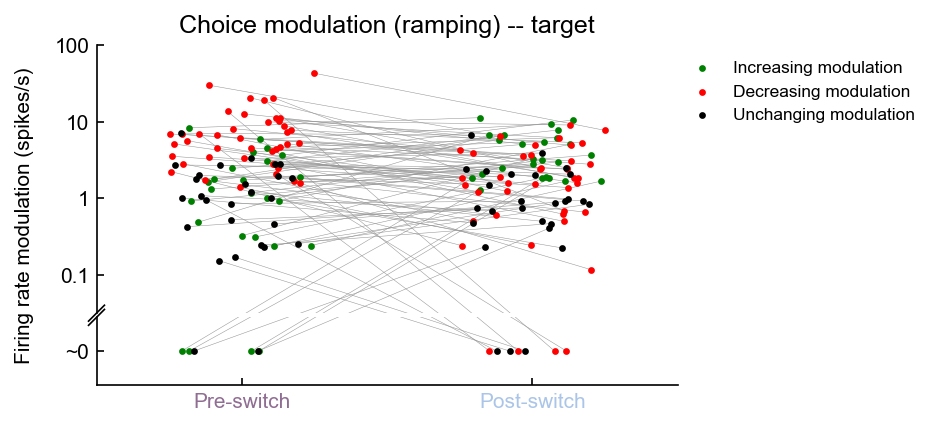

In [16]:
fig = plt.figure(figsize=(5, 3))
bax = brokenaxes(ylims=( (0.01/2.75,0.01*2.75), (0.03162277660168379, 100) ), hspace=0.025, yscale='log')

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_ramp_t),np.abs(post_ramp_t),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

X_plot = np.random.uniform(-0.25,0.25,size=len(data[0]))
for idx,(X_offset,column) in enumerate(zip(X,data)):
    Y_values = column
    X_values = X_plot+X_offset
    #ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c=PHASE_COLORS[idx+2])
    bax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c='green')
    bax.scatter(X_values[decrease_mask],Y_values[decrease_mask],s=5,c='red')
    bax.scatter(X_values[unchange_mask],Y_values[unchange_mask],s=5,c='k')
    
bax.plot([X_plot,X_plot+1],[data[0],data[1]],lw=0.25,zorder=-20,color=GOOD_GREY)

#############################################################################################

bax.scatter([],[],s=5,c='green',label='Increasing modulation')
bax.scatter([],[],s=5,c='red',label='Decreasing modulation')
bax.scatter([],[],s=5,c='k',label='Unchanging modulation')
lgd = bax.legend(frameon=False,loc=(1,0.75))

bax.set_ylabel('Firing rate modulation (spikes/s)')

bax.set_xlim([-0.5,1.5])
bax.axs[1].set_xticks([0,1])
bax.axs[1].set_xticklabels(['Pre-switch','Post-switch'])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(bax.axs[1].xaxis.get_ticklabels())]

for ax in bax.axs:
    ax.set_yscale('log',subs=[])
bax.axs[0].set_yticks([0.1,1,10,100])
bax.axs[0].set_yticklabels(['0.1','1','10','100'])
bax.axs[0].spines['bottom'].set_visible(False)
bax.axs[0].get_xaxis().set_visible(False)
bax.axs[1].set_yticks([0.01])
bax.axs[1].set_yticklabels(['~0'])

bax.set_title('Choice modulation (ramping) -- target')

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")

fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice switch modulation -- target.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice switch modulation -- target.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

Wilcoxon p = 3.8783694216167824e-08
Mann-whitney p = 5.847003552408831e-06


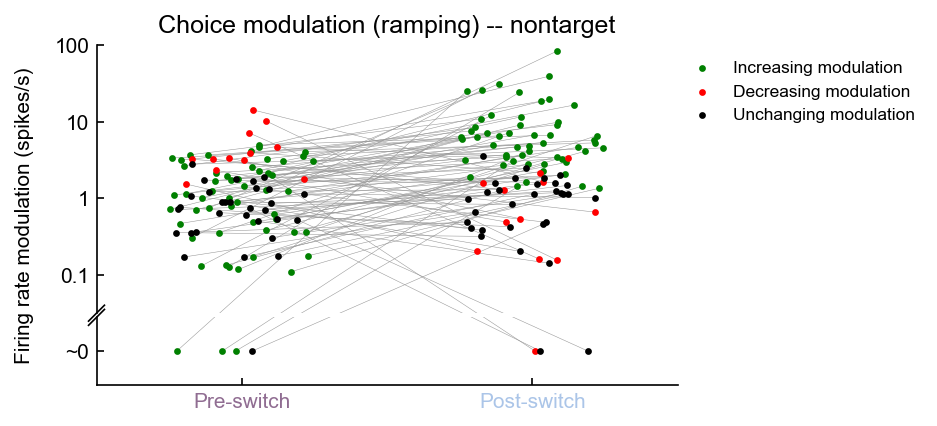

In [17]:
fig = plt.figure(figsize=(5, 3))
bax = brokenaxes(ylims=( (0.01/2.75,0.01*2.75), (0.03162277660168379, 100) ), hspace=0.025, yscale='log')

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_ramp_nt),np.abs(post_ramp_nt),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

X_plot = np.random.uniform(-0.25,0.25,size=len(data[0]))
for idx,(X_offset,column) in enumerate(zip(X,data)):
    Y_values = column
    X_values = X_plot+X_offset
    #ax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c=PHASE_COLORS[idx+2])
    bax.scatter(X_values[increase_mask],Y_values[increase_mask],s=5,c='green')
    bax.scatter(X_values[decrease_mask],Y_values[decrease_mask],s=5,c='red')
    bax.scatter(X_values[unchange_mask],Y_values[unchange_mask],s=5,c='k')
    
bax.plot([X_plot,X_plot+1],[data[0],data[1]],lw=0.25,zorder=-20,color=GOOD_GREY)

#############################################################################################

bax.scatter([],[],s=5,c='green',label='Increasing modulation')
bax.scatter([],[],s=5,c='red',label='Decreasing modulation')
bax.scatter([],[],s=5,c='k',label='Unchanging modulation')
lgd = bax.legend(frameon=False,loc=(1,0.75))

bax.set_ylabel('Firing rate modulation (spikes/s)')

bax.set_xlim([-0.5,1.5])
bax.axs[1].set_xticks([0,1])
bax.axs[1].set_xticklabels(['Pre-switch','Post-switch'])
colors = PHASE_COLORS[2:4]
[t.set_color(colors[idx]) for idx,t in enumerate(bax.axs[1].xaxis.get_ticklabels())]

for ax in bax.axs:
    ax.set_yscale('log',subs=[])
bax.axs[0].set_yticks([0.1,1,10,100])
bax.axs[0].set_yticklabels(['0.1','1','10','100'])
bax.axs[0].spines['bottom'].set_visible(False)
bax.axs[0].get_xaxis().set_visible(False)
bax.axs[1].set_yticks([0.01])
bax.axs[1].set_yticklabels(['~0'])

bax.set_title('Choice modulation (ramping) -- nontarget')

X,Y = ilep.paired_rmnan(data[0],data[1])
pvaluewil = wilcoxon(X,Y).pvalue
pvalueman = mannwhitneyu(X,Y).pvalue
print(f"Wilcoxon p = {pvaluewil}\nMann-whitney p = {pvalueman}")

fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice switch modulation -- nontarget.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice switch modulation -- nontarget.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Stimulus Pct change in modulation

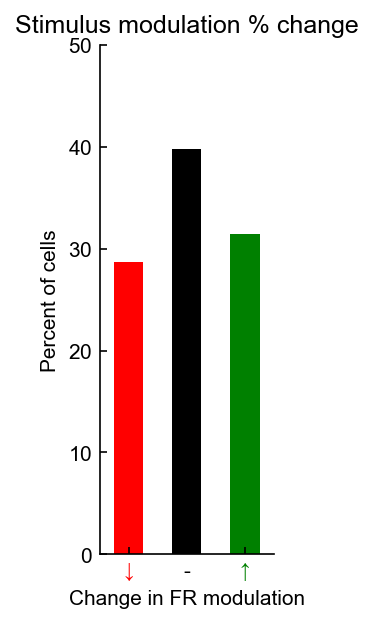

In [18]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_FR_mod),np.abs(post_FR_mod),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

pct_increase = np.mean(increase_mask)*100
pct_decrease = np.mean(decrease_mask)*100
pct_unchange = np.mean(unchange_mask)*100

ax.bar([0],[pct_decrease],color='red',width=0.5)
ax.bar([1],[pct_unchange],color='black',width=0.5)
ax.bar([2],[pct_increase],color='green',width=0.5)

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['↓','-','↑'])
colors = ['red','k','green']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR modulation')

ax.set_ylim([0,50])
ax.set_ylabel('Percent of cells')

ax.set_title('Stimulus modulation % change')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus modulation pct change.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus modulation pct change.png'),transparent=False,facecolor="white", bbox_inches='tight')

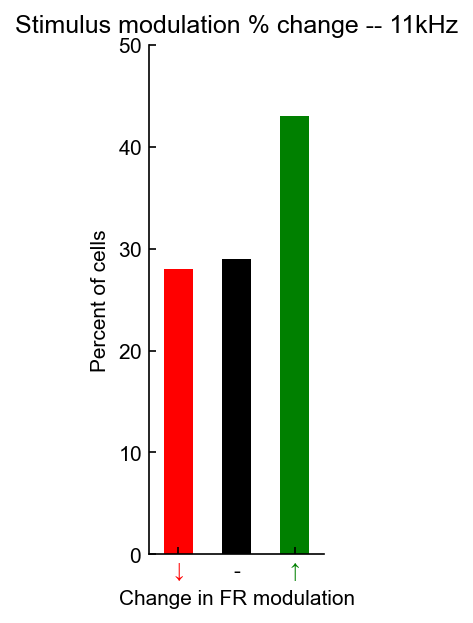

In [19]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_FR_mod_t),np.abs(post_FR_mod_nt),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

pct_increase = np.mean(increase_mask)*100
pct_decrease = np.mean(decrease_mask)*100
pct_unchange = np.mean(unchange_mask)*100

ax.bar([0],[pct_decrease],color='red',width=0.5)
ax.bar([1],[pct_unchange],color='black',width=0.5)
ax.bar([2],[pct_increase],color='green',width=0.5)

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['↓','-','↑'])
colors = ['red','k','green']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR modulation')

ax.set_ylim([0,50])
ax.set_ylabel('Percent of cells')

ax.set_title('Stimulus modulation % change -- 11kHz')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus modulation pct change -- 11kHz.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus modulation pct change -- 11kHz.png'),transparent=False,facecolor="white", bbox_inches='tight')

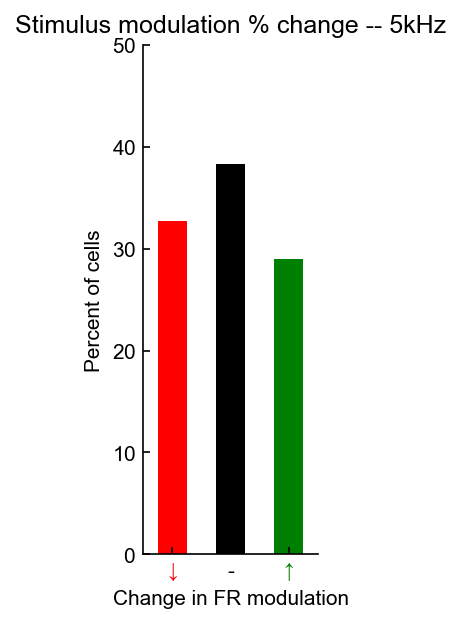

In [20]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_FR_mod_nt),np.abs(post_FR_mod_t),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

pct_increase = np.mean(increase_mask)*100
pct_decrease = np.mean(decrease_mask)*100
pct_unchange = np.mean(unchange_mask)*100

ax.bar([0],[pct_decrease],color='red',width=0.5)
ax.bar([1],[pct_unchange],color='black',width=0.5)
ax.bar([2],[pct_increase],color='green',width=0.5)

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['↓','-','↑'])
colors = ['red','k','green']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR modulation')

ax.set_ylim([0,50])
ax.set_ylabel('Percent of cells')

ax.set_title('Stimulus modulation % change -- 5kHz')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus modulation pct change -- 5kHz.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus modulation pct change -- 5kHz.png'),transparent=False,facecolor="white", bbox_inches='tight')

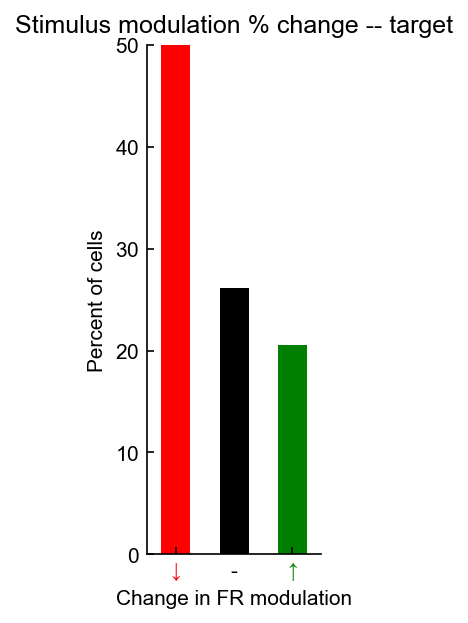

In [21]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_FR_mod_t),np.abs(post_FR_mod_t),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

pct_increase = np.mean(increase_mask)*100
pct_decrease = np.mean(decrease_mask)*100
pct_unchange = np.mean(unchange_mask)*100

ax.bar([0],[pct_decrease],color='red',width=0.5)
ax.bar([1],[pct_unchange],color='black',width=0.5)
ax.bar([2],[pct_increase],color='green',width=0.5)

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['↓','-','↑'])
colors = ['red','k','green']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR modulation')

ax.set_ylim([0,50])
ax.set_ylabel('Percent of cells')

ax.set_title('Stimulus modulation % change -- target')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus modulation pct change -- target.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus modulation pct change -- target.png'),transparent=False,facecolor="white", bbox_inches='tight')

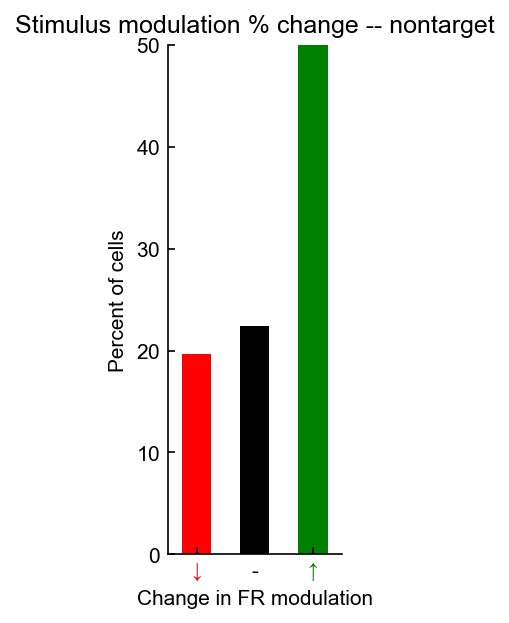

In [22]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_FR_mod_nt),np.abs(post_FR_mod_nt),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

pct_increase = np.mean(increase_mask)*100
pct_decrease = np.mean(decrease_mask)*100
pct_unchange = np.mean(unchange_mask)*100

ax.bar([0],[pct_decrease],color='red',width=0.5)
ax.bar([1],[pct_unchange],color='black',width=0.5)
ax.bar([2],[pct_increase],color='green',width=0.5)

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['↓','-','↑'])
colors = ['red','k','green']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR modulation')

ax.set_ylim([0,50])
ax.set_ylabel('Percent of cells')

ax.set_title('Stimulus modulation % change -- nontarget')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus modulation pct change -- nontarget.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Stimulus modulation pct change -- nontarget.png'),transparent=False,facecolor="white", bbox_inches='tight')

# Stimulus Pct change in modulation

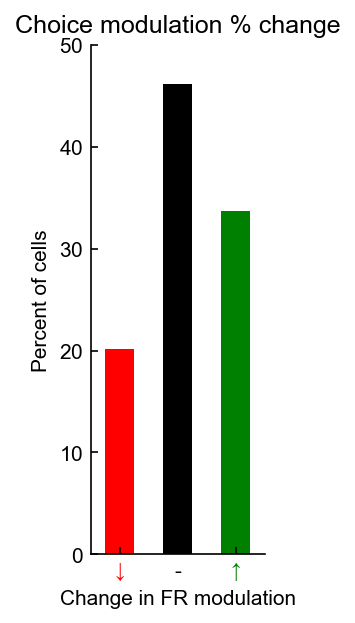

In [23]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_FR_ramp),np.abs(post_FR_ramp),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

pct_increase = np.mean(increase_mask)*100
pct_decrease = np.mean(decrease_mask)*100
pct_unchange = np.mean(unchange_mask)*100

ax.bar([0],[pct_decrease],color='red',width=0.5)
ax.bar([1],[pct_unchange],color='black',width=0.5)
ax.bar([2],[pct_increase],color='green',width=0.5)

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['↓','-','↑'])
colors = ['red','k','green']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR modulation')

ax.set_ylim([0,50])
ax.set_ylabel('Percent of cells')

ax.set_title('Choice modulation % change')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice modulation pct change.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice modulation pct change.png'),transparent=False,facecolor="white", bbox_inches='tight')

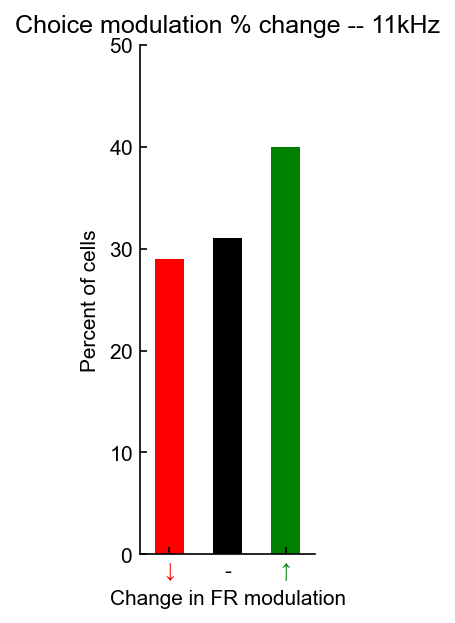

In [24]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_ramp_t),np.abs(post_ramp_nt),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

pct_increase = np.mean(increase_mask)*100
pct_decrease = np.mean(decrease_mask)*100
pct_unchange = np.mean(unchange_mask)*100

ax.bar([0],[pct_decrease],color='red',width=0.5)
ax.bar([1],[pct_unchange],color='black',width=0.5)
ax.bar([2],[pct_increase],color='green',width=0.5)

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['↓','-','↑'])
colors = ['red','k','green']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR modulation')

ax.set_ylim([0,50])
ax.set_ylabel('Percent of cells')

ax.set_title('Choice modulation % change -- 11kHz')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice modulation pct change -- 11kHz.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice modulation pct change -- 11kHz.png'),transparent=False,facecolor="white", bbox_inches='tight')

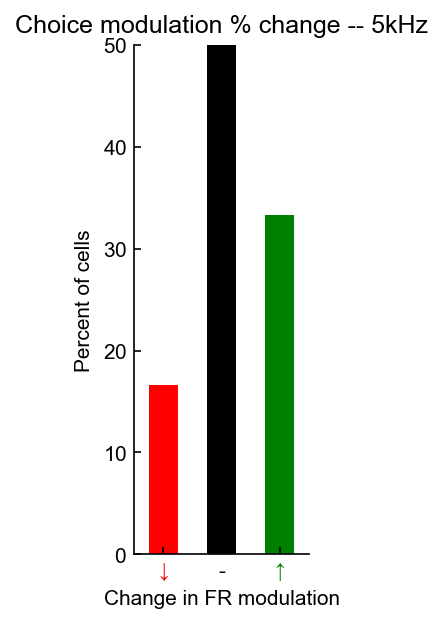

In [25]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_ramp_nt),np.abs(post_ramp_t),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

pct_increase = np.mean(increase_mask)*100
pct_decrease = np.mean(decrease_mask)*100
pct_unchange = np.mean(unchange_mask)*100

ax.bar([0],[pct_decrease],color='red',width=0.5)
ax.bar([1],[pct_unchange],color='black',width=0.5)
ax.bar([2],[pct_increase],color='green',width=0.5)

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['↓','-','↑'])
colors = ['red','k','green']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR modulation')

ax.set_ylim([0,50])
ax.set_ylabel('Percent of cells')

ax.set_title('Choice modulation % change -- 5kHz')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice modulation pct change -- 5kHz.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice modulation pct change -- 5kHz.png'),transparent=False,facecolor="white", bbox_inches='tight')

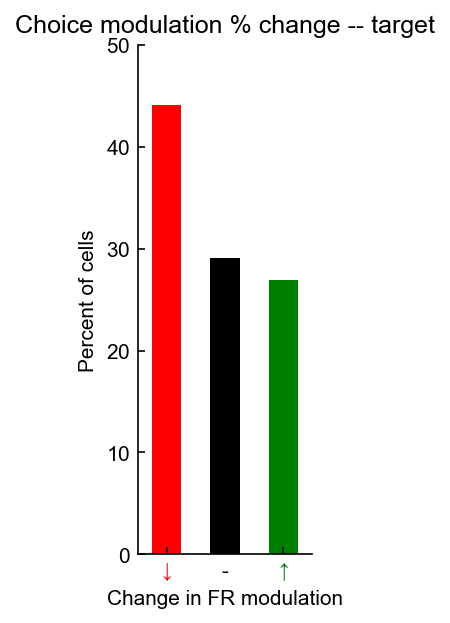

In [26]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_ramp_t),np.abs(post_ramp_t),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

pct_increase = np.mean(increase_mask)*100
pct_decrease = np.mean(decrease_mask)*100
pct_unchange = np.mean(unchange_mask)*100

ax.bar([0],[pct_decrease],color='red',width=0.5)
ax.bar([1],[pct_unchange],color='black',width=0.5)
ax.bar([2],[pct_increase],color='green',width=0.5)

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['↓','-','↑'])
colors = ['red','k','green']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR modulation')

ax.set_ylim([0,50])
ax.set_ylabel('Percent of cells')

ax.set_title('Choice modulation % change -- target')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice modulation pct change -- target.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice modulation pct change -- target.png'),transparent=False,facecolor="white", bbox_inches='tight')

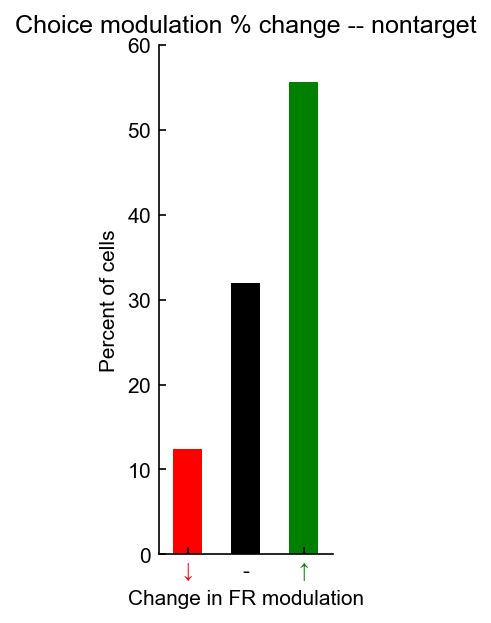

In [27]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

data = ilep.paired_rmnan(np.abs(pre_ramp_nt),np.abs(post_ramp_nt),positiveOnly=True)
for idx,column in enumerate(data):
    zero_mask = np.less(column,0.1)
    column[zero_mask] = 0.01
X = [np.ones_like(column)*idx for idx,column in enumerate(data)]

change_in_FR_mod = data[1]-data[0]
decrease_mask = np.less(change_in_FR_mod,-1)
increase_mask = np.greater(change_in_FR_mod,1)
unchange_mask = np.logical_not(np.logical_or(decrease_mask,increase_mask))

pct_increase = np.mean(increase_mask)*100
pct_decrease = np.mean(decrease_mask)*100
pct_unchange = np.mean(unchange_mask)*100

ax.bar([0],[pct_decrease],color='red',width=0.5)
ax.bar([1],[pct_unchange],color='black',width=0.5)
ax.bar([2],[pct_increase],color='green',width=0.5)

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['↓','-','↑'])
colors = ['red','k','green']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR modulation')

ax.set_ylim([0,60])
ax.set_ylabel('Percent of cells')

ax.set_title('Choice modulation % change -- nontarget')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice modulation pct change -- nontarget.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Choice modulation pct change -- nontarget.png'),transparent=False,facecolor="white", bbox_inches='tight')

# Switch day pct CR - NCR and vice versa

In [28]:
FRmod_median = 3.5533237685317998
data = ilep.paired_rmnan(pre_FR_mod,post_FR_mod)

pre_CR = np.greater(pre_FR_mod,FRmod_median)
post_CR = np.greater(post_FR_mod,FRmod_median)
pre_NCR = np.less(pre_FR_mod,FRmod_median)
post_NCR = np.less(post_FR_mod,FRmod_median)

CR_to_CR = np.logical_and(pre_CR,post_CR)
NCR_to_CR = np.logical_and(pre_NCR,post_CR)
CR_to_NCR = np.logical_and(pre_CR,post_NCR)
NCR_to_NCR = np.logical_and(pre_NCR,post_NCR)

print(np.mean(CR_to_CR))
print(np.mean(NCR_to_CR))
print(np.mean(CR_to_NCR))
print(np.mean(NCR_to_NCR))

0.28346456692913385
0.09448818897637795
0.14173228346456693
0.33070866141732286


In [29]:
usable_sessions = ['BS_108_3_AC.pickle','BS_40_14_AC.pickle','BS_41_1_AC.pickle','BS_42_1_AC.pickle','BS_72_3_AC.pickle']

In [30]:
num_cells = []

FRmod_median = 3.5533237685317998
data = ilep.paired_rmnan(pre_FR_mod,post_FR_mod)

for session in tqdm(usable_sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task != 'switch':
        continue
    if sessionfile.meta.animal not in animals:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    pre_FR = []
    post_FR  = []
    for clust in sessionfile.clusters.good:
        pre_FR_clust = sessionfile.responsiveness[clust]['pre_switch'].FRmodulation
        post_FR_clust = sessionfile.responsiveness[clust]['post_switch'].FRmodulation
        pre_FR.append(pre_FR_clust)
        post_FR.append(post_FR_clust)
    pre,post = ilep.paired_rmnan(pre_FR,post_FR)
    
    
    pre_CR = np.greater(pre_FR_mod,FRmod_median)
    post_CR = np.greater(post_FR_mod,FRmod_median)
    pre_NCR = np.less(pre_FR_mod,FRmod_median)
    post_NCR = np.less(post_FR_mod,FRmod_median)

    CR_to_CR = np.logical_and(pre_CR,post_CR)
    NCR_to_CR = np.logical_and(pre_NCR,post_CR)
    CR_to_NCR = np.logical_and(pre_CR,post_NCR)
    NCR_to_NCR = np.logical_and(pre_NCR,post_NCR)

100%|██████████| 5/5 [00:00<00:00, 80.63it/s]


In [31]:
num_cells

[]

In [32]:
data = ilep.paired_rmnan(pre_FR_mod_nt,post_FR_mod_nt)

In [33]:
data

(array([22.71062271,  2.5170068 ,  7.00680272,  2.78911565,  1.56462585,
        19.45578231,  4.62585034,  3.19727891,  0.95238095,  9.23076923,
         1.36054422,  2.75362319, 21.36054422,  0.74074074,  2.85714286,
         2.24489796,  2.5       ,  2.24489796,  3.94557823,  0.88435374,
        10.27210884,  2.92517007,  4.25287356,  0.6122449 ,  1.2244898 ,
         1.70068027,  2.58503401,  2.92517007,  2.77777778, 17.95918367,
         1.8556701 ,  1.44329897,  1.99312715,  1.50793651,  1.03092784,
         1.44329897,  0.96219931,  0.51948052,  0.96219931,  4.87972509,
         1.64948454,  0.96219931,  1.29032258,  0.89347079,  1.37457045,
         5.42955326,  1.58075601,  3.9862543 ,  2.26804124,  3.23024055,
         9.23611111,  4.44444444,  6.11111111,  6.66666667, 40.55555556,
         1.70212766,  0.20833333,  2.63888889, 22.29166667,  0.        ,
         2.63888889, 24.09722222, 17.56944444,  0.41666667,  2.98611111,
         0.83333333,  2.84722222,  1.52777778,  2.8

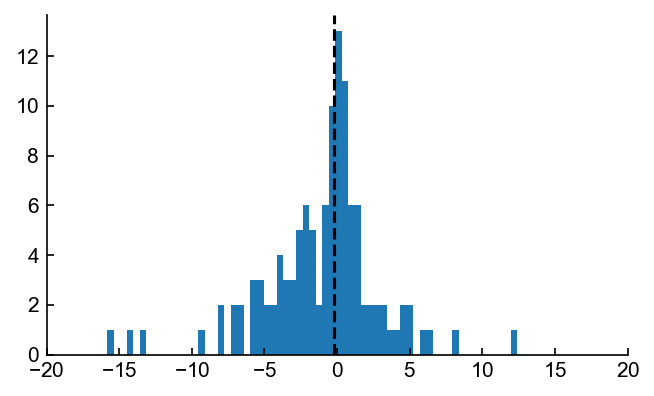

In [39]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(pre_FR_ramp,bins=100)
ax.set_xlim([-20,20])
ax.axvline(np.nanmedian(pre_FR_ramp),linestyle='--',zorder=10,color='k')
pass

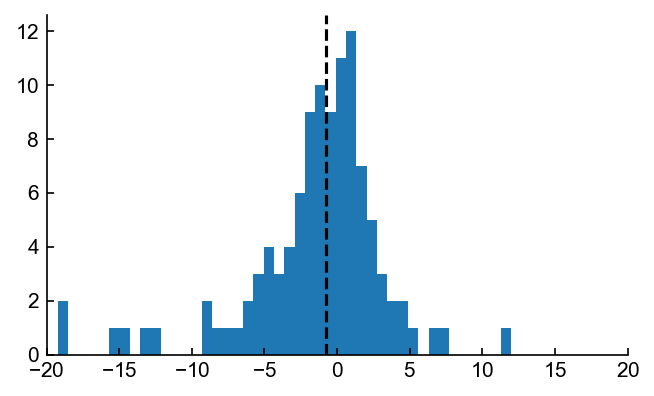

In [40]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(post_FR_ramp,bins=100)
ax.set_xlim([-20,20])
ax.axvline(np.nanmedian(post_FR_ramp),linestyle='--',zorder=10,color='k')
pass

In [34]:
FR_baseline_stim = 3.4547509983556486
FR_baseline_choice = 0.9498626865671642
print(f"pre_switch  stimulus NCR: {100*np.mean(np.less(ilep.rmnan(pre_FR_mod),FR_baseline_stim))}")
print(f"pre_switch  stimulus CR: {100*np.mean(np.greater(ilep.rmnan(pre_FR_mod),FR_baseline_stim))}")
print(f"post_switch stimulus NCR: {100*np.mean(np.less(ilep.rmnan(post_FR_mod),FR_baseline_stim))}")
print(f"post_switch stimulus CR: {100*np.mean(np.greater(ilep.rmnan(post_FR_mod),FR_baseline_stim))}")
print()
print(f"pre_switch  choice NCR: {100*np.mean(np.less(ilep.rmnan(np.abs(pre_FR_ramp)),FR_baseline_choice))}")
print(f"pre_switch  choice CR: {100*np.mean(np.greater(ilep.rmnan(np.abs(pre_FR_ramp)),FR_baseline_choice))}")
print(f"post_switch choice NCR: {100*np.mean(np.less(ilep.rmnan(np.abs(post_FR_ramp)),FR_baseline_choice))}")
print(f"post_switch choice CR: {100*np.mean(np.greater(ilep.rmnan(np.abs(post_FR_ramp)),FR_baseline_choice))}")

pre_switch  stimulus NCR: 49.59349593495935
pre_switch  stimulus CR: 50.40650406504065
post_switch stimulus NCR: 54.46428571428571
post_switch stimulus CR: 45.535714285714285

pre_switch  choice NCR: 33.33333333333333
pre_switch  choice CR: 66.66666666666666
post_switch choice NCR: 26.36363636363636
post_switch choice CR: 73.63636363636363


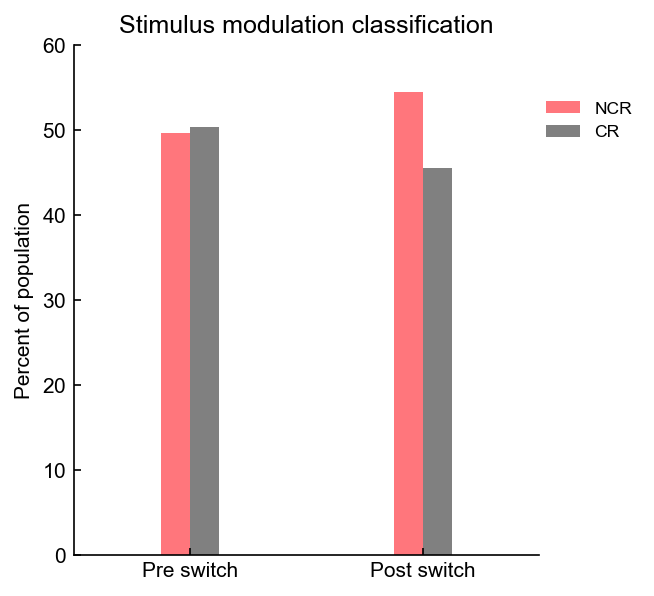

In [35]:
fig, ax = plt.subplots(figsize=(4,4.5))
ax.bar(np.array([0,1])-(1/16),[100*np.mean(np.less(ilep.rmnan(pre_FR_mod),FR_baseline_stim)),100*np.mean(np.less(ilep.rmnan(post_FR_mod),FR_baseline_stim))],color=NCR_COLOR,width=(1/8),label='NCR')
ax.bar(np.array([0,1])+(1/16),[100*np.mean(np.greater(ilep.rmnan(pre_FR_mod),FR_baseline_stim)),100*np.mean(np.greater(ilep.rmnan(post_FR_mod),FR_baseline_stim))],color=CR_COLOR,width=(1/8),label='CR')

ax.set_xlim([-0.5,1.5])
ax.set_xticks([0,1])
ax.set_xticklabels(['Pre switch','Post switch'])

ax.set_ylim([0,60])
ax.set_ylabel('Percent of population')

ax.set_title('Stimulus modulation classification')
lgd = ax.legend(frameon=False,loc=(1,0.8))
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Percent stimulus CR.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Percent stimulus CR.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

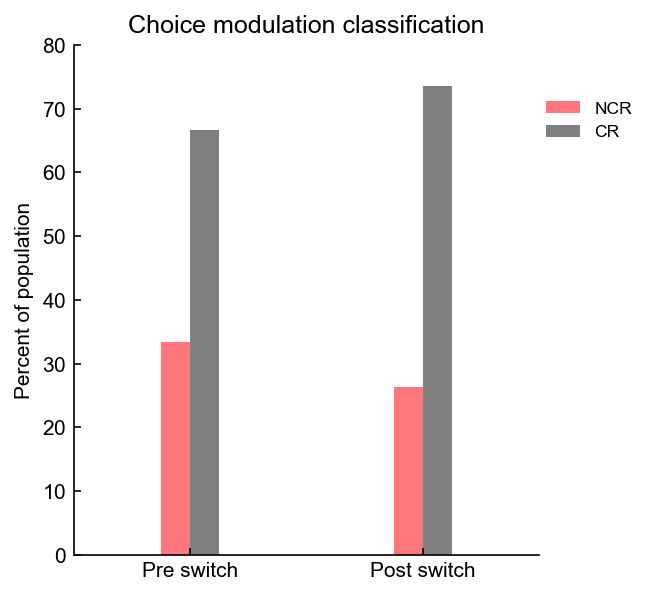

In [36]:
fig, ax = plt.subplots(figsize=(4,4.5))
ax.bar(np.array([0,1])-(1/16),[100*np.mean(np.less(ilep.rmnan(np.abs(pre_FR_ramp)),FR_baseline_choice)),100*np.mean(np.less(ilep.rmnan(np.abs(post_FR_ramp)),FR_baseline_choice))],color=NCR_COLOR,width=(1/8),label='NCR')
ax.bar(np.array([0,1])+(1/16),[100*np.mean(np.greater(ilep.rmnan(np.abs(pre_FR_ramp)),FR_baseline_choice)),100*np.mean(np.greater(ilep.rmnan(np.abs(post_FR_ramp)),FR_baseline_choice))],color=CR_COLOR,width=(1/8),label='CR')

ax.set_xlim([-0.5,1.5])
ax.set_xticks([0,1])
ax.set_xticklabels(['Pre switch','Post switch'])

ax.set_ylim([0,80])
ax.set_ylabel('Percent of population')

ax.set_title('Choice modulation classification')
lgd = ax.legend(frameon=False,loc=(1,0.8))
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Percent choice CR.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Percent choice CR.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [40]:
class TrialInterval:
    _startTimeSamples = 0
    _endTimeSamples = 0
    _isStartTimeRelToResponse = True
    _isEndTimeRelToResponse = True
    _averageLickDelay = 0.2 * 30000

    def __init__(self,start,end,startresp,endresp):
        self._startTimeSamples = start
        self._endTimeSamples = end
        self._isStartTimeRelToResponse = startresp
        self._isEndTimeRelToResponse = endresp

    def _CalculateAvgLickDelay(self,sessionfile):
        go_responses = np.array(sessionfile.trials.response)[sessionfile.trials.go]
        go_starts = np.array(sessionfile.trials.starts)[sessionfile.trials.go]
        self._averageLickDelay = np.nanmean(go_responses - go_starts)

    def _ToTimestamp(self,sessionfile,trial):
        starttime = sessionfile.trials.starts[trial]
        if self._isStartTimeRelToResponse:
            starttime = sessionfile.trials.response[trial]
            if np.isnan(starttime):
                starttime = sessionfile.trials.starts[trial] + self._averageLickDelay
        starttime = starttime + self._startTimeSamples

        endtime = sessionfile.trials.starts[trial]
        if self._isEndTimeRelToResponse:
            endtime = sessionfile.trials.response[trial]
            if np.isnan(endtime):
                endtime = sessionfile.trials.starts[trial] + self._averageLickDelay
        endtime = endtime + self._endTimeSamples

        return [starttime,endtime]

    def _ToString(self):
        return f"Interval has start {self._startTimeSamples}, end {self._startTimeSamples}. startresp {self._isStartTimeRelToResponse} and endresp {self._isEndTimeRelToResponse}"

In [41]:
#this function calculates pval for one cluster(one cell)
def calculate_NCR_CR_pval(sessionfile,clust):

    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1
    trials_to_use = sessionfile.trim[clust].trimmed_trials

    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.starts[trial]

    #tone play end time
    onset_window_end_time = onset_window_start_time + window
    #offset window start time
    offset_window_start_time = onset_window_end_time
    #offset window end time
    offset_window_end_time = offset_window_start_time + window
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),2,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window_start_time[i],offset_window_end_time[i]]
                            ]

    #create array for baseline period
    base_window1_start = onset_window_start_time - 3*window
    base_window1_end = onset_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = onset_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = onset_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),2))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from offset window
        spikecount_offsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow

    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(2)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)

        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)
    return p_value_evoked, p_value_suppressed, p_value_NCR

In [91]:
def statisticalComparison(sessionfile,clust,preCondition,postCondition,preInterval,postInterval,iterations=5000,sample_percent=0.5,pthresh=0.95,modthresh=0.1):
    if pthresh < 0.5:
        raise Exception('pthresh cannot be less than 50%!')
    
    preInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    postInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    
    allConditions = ilep.getAllConditions(sessionfile,clust)
    preTrials = allConditions[preCondition].trials
    postTrials = allConditions[postCondition].trials
    
    if preCondition == postCondition:
        paired=True
    else:
        paired=False
    
    preTrialRates = np.full_like(preTrials,np.nan,dtype='float')
    postTrialRates = np.full_like(postTrials,np.nan,dtype='float')
    
    for idx,trial in enumerate(preTrials):
        start,end = preInterval._ToTimestamp(sessionfile,trial)
        spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
        preTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
        
    for idx,trial in enumerate(postTrials):
        start,end = postInterval._ToTimestamp(sessionfile,trial)
        spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
        postTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
    
    increased=0
    decreased=0
    unchanged=0
    
    for i in range(iterations):
        if paired and len(preTrialRates) != len(preTrialRates):
            raise Exception('Non-equal length paired comparison')
        if paired:
            raise Exception('Paired comparison is not yet implemented')
        else:
            preIdxs = range(len(preTrialRates))
            postIdxs = range(len(postTrialRates))
            preIdxs = np.random.permutation(preIdxs)
            postIdxs = np.random.permutation(postIdxs)
            maxIdx = int(sample_percent*min(len(preIdxs),len(postIdxs)))
            preIdxs = preIdxs[range(maxIdx)]
            postIdxs = postIdxs[range(maxIdx)]
            
        preTrialsToCompare = preTrialRates[preIdxs]
        postTrialsToCompare = postTrialRates[postIdxs]
        
        deltaTrialMean = np.mean(postTrialsToCompare - preTrialsToCompare)
        
        if deltaTrialMean >= modthresh:
            increased+=1
        elif deltaTrialMean <= -modthresh:
            decreased+=1
        else:
            unchanged+=1
            
    p_increased = increased / (increased+decreased+unchanged)
    p_decreased = decreased / (increased+decreased+unchanged)
    p_unchanged = unchanged / (increased+decreased+unchanged)
    
    print(f"inc: {p_increased}, dec: {p_decreased}, unch: {p_unchanged}")
    
    if p_increased >= pthresh:
        label='increased'
        pval = 1-p_increased
    elif p_decreased >= pthresh:
        label='decreased'
        pval = 1-p_decreased
    elif p_unchanged >= pthresh:
        label='unchanged'
        pval = 1-p_unchanged
    else:
        label='inconclusive'
        pval=1-np.max([p_increased,p_decreased,p_unchanged])
    return label,pval

In [103]:
preInterval  = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
postInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
statisticalComparison(sessionfile,sessionfile.clusters.good[0],'target','nontarget',preInterval,postInterval,sample_percent=0.95,pthresh=0.75,modthresh=1,iterations=5000)

inc: 0.0, dec: 0.0, unch: 1.0


('unchanged', 0.0)

In [16]:
class TrialInterval:
    _startTimeSamples = 0
    _endTimeSamples = 0
    _isStartTimeRelToResponse = True
    _isEndTimeRelToResponse = True
    _averageLickDelay = 0.2 * 30000

    def __init__(self,start,end,startresp,endresp):
        self._startTimeSamples = start
        self._endTimeSamples = end
        self._isStartTimeRelToResponse = startresp
        self._isEndTimeRelToResponse = endresp

    def _CalculateAvgLickDelay(self,sessionfile):
        go_responses = np.array(sessionfile.trials.response)[sessionfile.trials.go]
        go_starts = np.array(sessionfile.trials.starts)[sessionfile.trials.go]
        self._averageLickDelay = np.nanmean(go_responses - go_starts)

    def _ToTimestamp(self,sessionfile,trial):
        starttime = sessionfile.trials.starts[trial]
        if self._isStartTimeRelToResponse:
            starttime = sessionfile.trials.response[trial]
            if np.isnan(starttime):
                starttime = sessionfile.trials.starts[trial] + self._averageLickDelay
        starttime = starttime + self._startTimeSamples

        endtime = sessionfile.trials.starts[trial]
        if self._isEndTimeRelToResponse:
            endtime = sessionfile.trials.response[trial]
            if np.isnan(endtime):
                endtime = sessionfile.trials.starts[trial] + self._averageLickDelay
        endtime = endtime + self._endTimeSamples

        return [starttime,endtime]

    def _ToString(self):
        return f"Interval has start {self._startTimeSamples}, end {self._startTimeSamples}. startresp {self._isStartTimeRelToResponse} and endresp {self._isEndTimeRelToResponse}"

# def statisticalComparison(sessionfile,clust,preCondition,postCondition):
#     preInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
#     postInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    
#     allConditions = ilep.getAllConditions(sessionfile,clust)
#     preTrials = allConditions[preCondition].trials
#     postTrials = allConditions[postCondition].trials
        
#     preTrialRates = np.full_like(preTrials,np.nan,dtype='float')
#     postTrialRates = np.full_like(postTrials,np.nan,dtype='float')    
#     for idx,trial in enumerate(preTrials):
#         start,end = preInterval._ToTimestamp(sessionfile,trial)
#         spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
#         preTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
#     for idx,trial in enumerate(postTrials):
#         start,end = postInterval._ToTimestamp(sessionfile,trial)
#         spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
#         postTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
        
#     pvalue_inc = mannwhitneyu(preTrialRates,postTrialRates,alternative='less').pvalue
#     pvalue_dec = mannwhitneyu(preTrialRates,postTrialRates,alternative='greater').pvalue
#     if pvalue_inc <= 0.05:# and np.median(postTrialRates) > np.median(preTrialRates):
#         label = 'increased'
#         pvalue = pvalue_inc
#     elif pvalue_dec <= 0.05:# and np.median(postTrialRates) < np.median(preTrialRates):
#         label = 'decreased'
#         pvalue = pvalue_dec
#     else:
#         label = 'unchanged'
#         pvalue = np.min(pvalue_inc,pvalue_dec)
#     return label,pvalue

def statisticalComparison(sessionfile,clust,preCondition,postCondition,preInterval,postInterval,iterations=5000,sample_percent=0.5,pthresh=0.95,modthresh=0.1):
    if pthresh < 0.5:
        raise Exception('pthresh cannot be less than 50%!')
    
    allConditions = ilep.getAllConditions(sessionfile,clust)
    preTrials = allConditions[preCondition].trials
    postTrials = allConditions[postCondition].trials
    
    if preCondition == postCondition:
        paired=True
    else:
        paired=False
    
    preTrialRates = np.full_like(preTrials,np.nan,dtype='float')
    postTrialRates = np.full_like(postTrials,np.nan,dtype='float')
    
    for idx,trial in enumerate(preTrials):
        start,end = preInterval._ToTimestamp(sessionfile,trial)
        spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
        preTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
        
    for idx,trial in enumerate(postTrials):
        start,end = postInterval._ToTimestamp(sessionfile,trial)
        spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
        postTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
    
    increased=0
    decreased=0
    unchanged=0
    
    for i in range(iterations):
        if paired and len(preTrialRates) != len(preTrialRates):
            raise Exception('Non-equal length paired comparison')
        if paired:
            raise Exception('Paired comparison is not yet implemented')
        else:
            preIdxs = range(len(preTrialRates))
            postIdxs = range(len(postTrialRates))
            preIdxs = np.random.permutation(preIdxs)
            postIdxs = np.random.permutation(postIdxs)
            maxIdx = int(sample_percent*min(len(preIdxs),len(postIdxs)))
            preIdxs = preIdxs[range(maxIdx)]
            postIdxs = postIdxs[range(maxIdx)]
            
        preTrialsToCompare = preTrialRates[preIdxs]
        postTrialsToCompare = postTrialRates[postIdxs]
        
        deltaTrialMean = np.mean(postTrialsToCompare - preTrialsToCompare)
        
        if deltaTrialMean >= modthresh:
            increased+=1
        elif deltaTrialMean <= -modthresh:
            decreased+=1
        else:
            unchanged+=1
            
    p_increased = increased / (increased+decreased+unchanged)
    p_decreased = decreased / (increased+decreased+unchanged)
    p_unchanged = unchanged / (increased+decreased+unchanged)
    
    if p_increased >= pthresh:
        label='increased'
        pval = 1-p_increased
    elif p_decreased >= pthresh:
        label='decreased'
        pval = 1-p_decreased
    elif p_unchanged >= pthresh:
        label='unchanged'
        pval = 1-p_unchanged
    else:
        label='inconclusive'
        pval=1-np.max([p_increased,p_decreased,p_unchanged])
    return label,pval

In [17]:
num_increased = 0
num_decreased = 0
num_unchanged = 0
num_inconclusive = 0

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task != 'switch':
        continue
    if sessionfile.meta.animal not in animals:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    for clust in sessionfile.clusters.good:
        
        preInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
        postInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
        try:
            label,pval = statisticalComparison(sessionfile,clust,'pre_switch','post_switch',preInterval,postInterval,sample_percent=0.95,pthresh=0.95,modthresh=1,iterations=5000)
        except:
            label='inconclusive'
            pval=1
        if label == 'increased':
            num_increased += 1
        elif label == 'decreased':
            num_decreased += 1
        elif label == 'unchanged':
            num_unchanged += 1
        else:
            num_inconclusive += 1

100%|██████████| 592/592 [01:16<00:00,  7.76it/s]


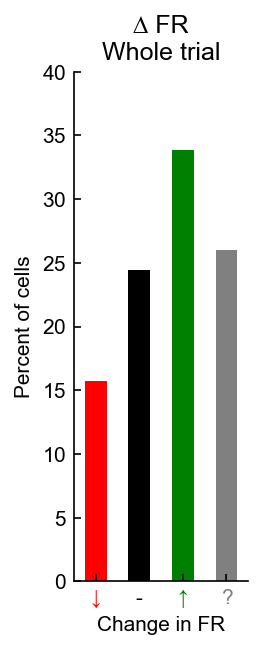

In [18]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

pct_increased = num_increased / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100
pct_decreased = num_decreased / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100
pct_unchanged = num_unchanged / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100
pct_inconclusive = num_inconclusive / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100

ax.bar([0],[pct_decreased],color='red',width=0.5)
ax.bar([1],[pct_unchanged],color='black',width=0.5)
ax.bar([2],[pct_increased],color='green',width=0.5)
ax.bar([3],[pct_inconclusive],color='grey',width=0.5)

ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['↓','-','↑','?'])
colors = ['red','k','green','grey']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR')

ax.set_ylim([0,40])
ax.set_ylabel('Percent of cells')

ax.set_title('∆ FR\nWhole trial')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','FR change whole trial.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','FR change whole trial.png'),transparent=False,facecolor="white", bbox_inches='tight')

In [19]:
num_increased = 0
num_decreased = 0
num_unchanged = 0
num_inconclusive = 0

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task != 'switch':
        continue
    if sessionfile.meta.animal not in animals:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    for clust in sessionfile.clusters.good:
        
        preInterval = TrialInterval(0,0.2*sessionfile.meta.fs,False,False)
        postInterval = TrialInterval(0,0.2*sessionfile.meta.fs,False,False)
        try:
            label,pval = statisticalComparison(sessionfile,clust,'pre_switch','post_switch',preInterval,postInterval,sample_percent=0.95,pthresh=0.95,modthresh=1,iterations=5000)
        except:
            label='inconclusive'
            pval=1
        if label == 'increased':
            num_increased += 1
        elif label == 'decreased':
            num_decreased += 1
        elif label == 'unchanged':
            num_unchanged += 1
        else:
            num_inconclusive += 1

100%|██████████| 592/592 [01:16<00:00,  7.76it/s]


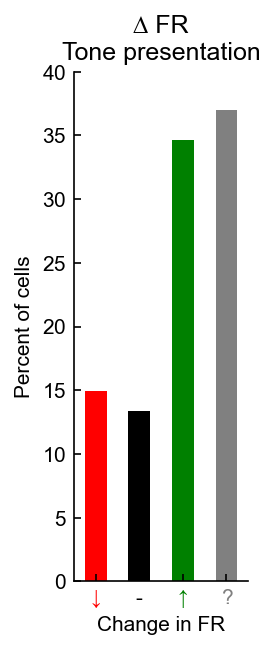

In [20]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

pct_increased = num_increased / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100
pct_decreased = num_decreased / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100
pct_unchanged = num_unchanged / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100
pct_inconclusive = num_inconclusive / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100

ax.bar([0],[pct_decreased],color='red',width=0.5)
ax.bar([1],[pct_unchanged],color='black',width=0.5)
ax.bar([2],[pct_increased],color='green',width=0.5)
ax.bar([3],[pct_inconclusive],color='grey',width=0.5)

ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['↓','-','↑','?'])
colors = ['red','k','green','grey']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR')

ax.set_ylim([0,40])
ax.set_ylabel('Percent of cells')

ax.set_title('∆ FR\nTone presentation')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','FR change tone presentation.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','FR change tone presentation.png'),transparent=False,facecolor="white", bbox_inches='tight')

In [21]:
num_increased = 0
num_decreased = 0
num_unchanged = 0
num_inconclusive = 0

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task != 'switch':
        continue
    if sessionfile.meta.animal not in animals:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    for clust in sessionfile.clusters.good:
        
        preInterval = TrialInterval(-0.2*sessionfile.meta.fs,0,True,True)
        postInterval = TrialInterval(-0.2*sessionfile.meta.fs,0,True,True)
        try:
            label,pval = statisticalComparison(sessionfile,clust,'pre_switch','post_switch',preInterval,postInterval,sample_percent=0.95,pthresh=0.95,modthresh=1,iterations=5000)
        except:
            label='inconclusive'
            pval=1
        if label == 'increased':
            num_increased += 1
        elif label == 'decreased':
            num_decreased += 1
        elif label == 'unchanged':
            num_unchanged += 1
        else:
            num_inconclusive += 1

100%|██████████| 592/592 [01:16<00:00,  7.73it/s]


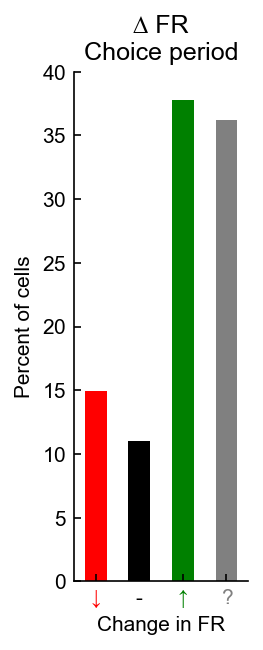

In [22]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

pct_increased = num_increased / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100
pct_decreased = num_decreased / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100
pct_unchanged = num_unchanged / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100
pct_inconclusive = num_inconclusive / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100

ax.bar([0],[pct_decreased],color='red',width=0.5)
ax.bar([1],[pct_unchanged],color='black',width=0.5)
ax.bar([2],[pct_increased],color='green',width=0.5)
ax.bar([3],[pct_inconclusive],color='grey',width=0.5)

ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['↓','-','↑','?'])
colors = ['red','k','green','grey']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR')

ax.set_ylim([0,40])
ax.set_ylabel('Percent of cells')

ax.set_title('∆ FR\nChoice period')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','FR change choice period.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','FR change choice period.png'),transparent=False,facecolor="white", bbox_inches='tight')

In [23]:
num_increased = 0
num_decreased = 0
num_unchanged = 0
num_inconclusive = 0

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task != 'switch':
        continue
    if sessionfile.meta.animal not in animals:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    for clust in sessionfile.clusters.good:
        
        preInterval = TrialInterval(-0.2*sessionfile.meta.fs,0,False,False)
        postInterval = TrialInterval(-0.2*sessionfile.meta.fs,0,False,False)
        try:
            label,pval = statisticalComparison(sessionfile,clust,'pre_switch','post_switch',preInterval,postInterval,sample_percent=0.95,pthresh=0.95,modthresh=1,iterations=5000)
        except:
            label='inconclusive'
            pval=1
        if label == 'increased':
            num_increased += 1
        elif label == 'decreased':
            num_decreased += 1
        elif label == 'unchanged':
            num_unchanged += 1
        else:
            num_inconclusive += 1

100%|██████████| 592/592 [01:16<00:00,  7.74it/s]


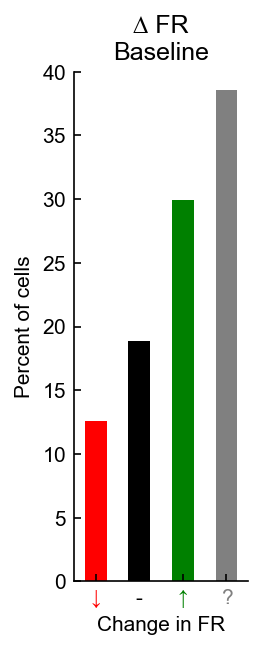

In [24]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

#############################################################################################

pct_increased = num_increased / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100
pct_decreased = num_decreased / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100
pct_unchanged = num_unchanged / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100
pct_inconclusive = num_inconclusive / (num_increased+num_decreased+num_unchanged+num_inconclusive) * 100

ax.bar([0],[pct_decreased],color='red',width=0.5)
ax.bar([1],[pct_unchanged],color='black',width=0.5)
ax.bar([2],[pct_increased],color='green',width=0.5)
ax.bar([3],[pct_inconclusive],color='grey',width=0.5)

ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['↓','-','↑','?'])
colors = ['red','k','green','grey']
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]
ax.set_xlabel('Change in FR')

ax.set_ylim([0,40])
ax.set_ylabel('Percent of cells')

ax.set_title('∆ FR\nBaseline')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','FR change balseline.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','FR change baseline.png'),transparent=False,facecolor="white", bbox_inches='tight')

In [28]:
animal = 'BS_40'

In [32]:
animalBehaviors[animal].sessions[switch_day]

namespace(animal='BS_40',
          session=18,
          files=array(['BS_40_18v1.txt', 'BS_40_18v2_reversal.txt',
                       'BS_40_18v3_reversal.txt', 'BS_40_18v4_reversal.txt',
                       'BS_40_18v5_reversal.txt', 'BS_40_18v6_reversal.txt'], dtype='<U23'),
          blocknumbers=array([1, 2, 3, 4, 5, 6]),
          type='switch',
          trials_per_session=array([200., 100.,  35.,  61.,  82.,  33.]),
          outcomes=0     1
                   1     1
                   2     2
                   3     1
                   4     1
                        ..
                   28    2
                   29    3
                   30    2
                   31    4
                   32    2
                   Name: outcome, Length: 511, dtype: int64,
          tones=0     11260
                1     11260
                2     11260
                3     11260
                4     11260
                      ...  
                28     5648
           

# Behavior analysis

In [22]:
with open('C:\\Users\\insan\\Desktop\\trialsToUsePerDay', 'rb') as f:
    trialsPerDayLoaded = pickle.load(f)
    
pre_hit = []
pre_miss = []
pre_falarm = []
pre_creject = []

post_hit = []
post_miss = []
post_falarm = []
post_creject = []
    
for animal in tqdm(animals):
    switch_day = animalBehaviors[animal].reversal
    outcomes = np.array(animalBehaviors[animal].sessions[switch_day].outcomes)
    active_trials = trialsPerDayLoaded[animal][switch_day]
    num_pre_reversal = int(animalBehaviors[animal].sessions[switch_day].trials_per_session[0])
    num_total = int(np.sum(animalBehaviors[animal].sessions[switch_day].trials_per_session))
    pre_reversal = np.array(range(num_pre_reversal))
    post_reversal = np.array(range(num_pre_reversal,num_total))
    pre_reversal = pre_reversal[np.isin(pre_reversal,active_trials)]
    post_reversal = post_reversal[np.isin(post_reversal,active_trials)]
    
    pre_outcomes = outcomes[pre_reversal]
    post_outcomes = outcomes[post_reversal]
    
    pre_hit.append(np.mean(np.equal(pre_outcomes,1))*100)
    pre_miss.append(np.mean(np.equal(pre_outcomes,2))*100)
    pre_falarm.append(np.mean(np.equal(pre_outcomes,3))*100)
    pre_creject.append(np.mean(np.equal(pre_outcomes,4))*100)
    
    post_hit.append(np.mean(np.equal(post_outcomes,1))*100)
    post_miss.append(np.mean(np.equal(post_outcomes,2))*100)
    post_falarm.append(np.mean(np.equal(post_outcomes,3))*100)
    post_creject.append(np.mean(np.equal(post_outcomes,4))*100)

100%|██████████| 18/18 [00:00<00:00, 1635.95it/s]


In [23]:
pre_lick_11khz = np.full_like(pre_hit,np.nan)
post_lick_11khz = np.full_like(post_hit,np.nan)
pre_lick_5khz = np.full_like(pre_hit,np.nan)
post_lick_5khz = np.full_like(post_hit,np.nan)

for idx,(h,m,f,c) in enumerate(zip(pre_hit,pre_miss,pre_falarm,pre_creject)):
    pre_lick_11khz[idx] = h / (h+m) * 100
    pre_lick_5khz[idx] = f / (f+c) * 100

for idx,(h,m,f,c) in enumerate(zip(post_hit,post_miss,post_falarm,post_creject)):
    post_lick_11khz[idx] = f / (f+c) * 100
    post_lick_5khz[idx] = h / (h+m) * 100

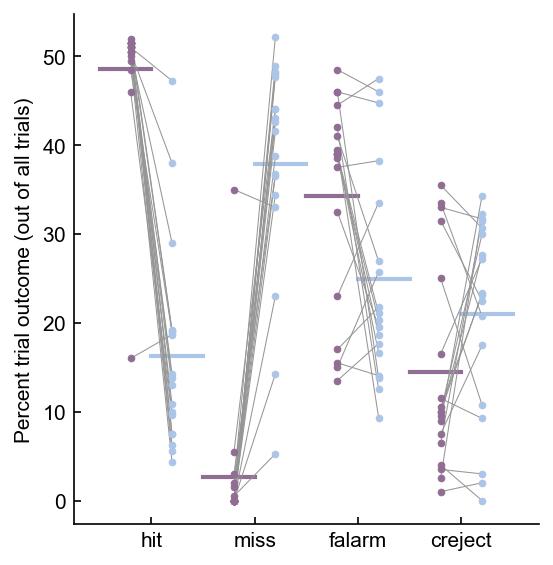

In [24]:
fig, ax = plt.subplots(figsize=(4,4.5))

width = 0.2
ax.plot([0-width,0+width],[pre_hit,post_hit],lw=0.5,color=GOOD_GREY,zorder=-10)
ax.plot([1-width,1+width],[pre_miss,post_miss],lw=0.5,color=GOOD_GREY,zorder=-10)
ax.plot([2-width,2+width],[pre_falarm,post_falarm],lw=0.5,color=GOOD_GREY,zorder=-10)
ax.plot([3-width,3+width],[pre_creject,post_creject],lw=0.5,color=GOOD_GREY,zorder=-10)

ax.scatter(np.zeros_like(pre_hit)+0-width,pre_hit,lw=0.5,zorder=1,color=PHASE_COLORS[2],s=10)
ax.scatter(np.zeros_like(pre_miss)+1-width,pre_miss,lw=0.5,color=PHASE_COLORS[2],s=10)
ax.scatter(np.zeros_like(pre_falarm)+2-width,pre_falarm,lw=0.5,color=PHASE_COLORS[2],s=10)
ax.scatter(np.zeros_like(pre_creject)+3-width,pre_creject,lw=0.5,color=PHASE_COLORS[2],s=10)

ax.scatter(np.zeros_like(post_hit)+0+width,post_hit,lw=0.5,zorder=1,color=PHASE_COLORS[3],s=10)
ax.scatter(np.zeros_like(post_miss)+1+width,post_miss,lw=0.5,color=PHASE_COLORS[3],s=10)
ax.scatter(np.zeros_like(post_falarm)+2+width,post_falarm,lw=0.5,color=PHASE_COLORS[3],s=10)
ax.scatter(np.zeros_like(post_creject)+3+width,post_creject,lw=0.5,color=PHASE_COLORS[3],s=10)

ax.plot([0-width-width*1.5,0],[np.mean(pre_hit)]*2,color=PHASE_COLORS[2],lw=2,zorder=-20)
ax.plot([0,0+width+width*1.5],[np.mean(post_hit)]*2,color=PHASE_COLORS[3],lw=2,zorder=-20)

ax.plot([1-width-width*1.5,1],[np.mean(pre_miss)]*2,color=PHASE_COLORS[2],lw=2,zorder=-20)
ax.plot([1,1+width+width*1.5],[np.mean(post_miss)]*2,color=PHASE_COLORS[3],lw=2,zorder=-20)

ax.plot([2-width-width*1.5,2],[np.mean(pre_falarm)]*2,color=PHASE_COLORS[2],lw=2,zorder=-20)
ax.plot([2,2+width+width*1.5],[np.mean(post_falarm)]*2,color=PHASE_COLORS[3],lw=2,zorder=-20)

ax.plot([3-width-width*1.5,3],[np.mean(pre_creject)]*2,color=PHASE_COLORS[2],lw=2,zorder=-20)
ax.plot([3,3+width+width*1.5],[np.mean(post_creject)]*2,color=PHASE_COLORS[3],lw=2,zorder=-20)

ax.set_xlim([-0.75,3.75])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['hit','miss','falarm','creject'])

ax.set_ylabel('Percent trial outcome (out of all trials)')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Trial outcomes pre-post.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Trial outcomes pre-post.png'),transparent=False,facecolor="white", bbox_inches='tight')

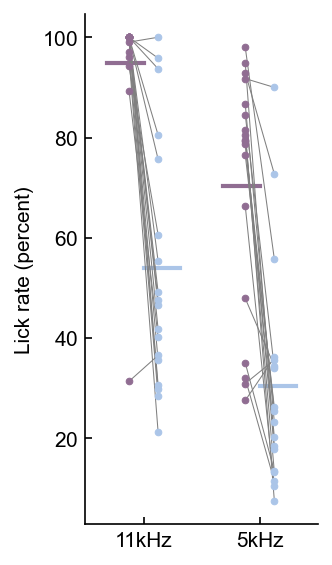

In [40]:
fig, ax = plt.subplots(figsize=(2,4.5))

width = 0.125
ax.plot([0-width,0+width],[pre_lick_11khz,post_lick_11khz],lw=0.5,color='grey',zorder=-10)
ax.plot([1-width,1+width],[pre_lick_5khz,post_lick_5khz],lw=0.5,color='grey',zorder=-10)

ax.scatter(np.zeros_like(pre_lick_11khz)+0-width,pre_lick_11khz,lw=0.5,zorder=1,color=PHASE_COLORS[2],s=10)
ax.scatter(np.zeros_like(pre_lick_5khz)+1-width,pre_lick_5khz,lw=0.5,zorder=1,color=PHASE_COLORS[2],s=10)

ax.scatter(np.zeros_like(post_lick_11khz)+0+width,post_lick_11khz,lw=0.5,zorder=1,color=PHASE_COLORS[3],s=10)
ax.scatter(np.zeros_like(post_lick_5khz)+1+width,post_lick_5khz,lw=0.5,zorder=1,color=PHASE_COLORS[3],s=10)

ax.plot([0-width-width*1.5,0],[np.mean(pre_lick_11khz)]*2,color=PHASE_COLORS[2],lw=2,zorder=-20)
ax.plot([0,0+width+width*1.5],[np.mean(post_lick_11khz)]*2,color=PHASE_COLORS[3],lw=2,zorder=-20)

ax.plot([1-width-width*1.5,1],[np.mean(pre_lick_5khz)]*2,color=PHASE_COLORS[2],lw=2,zorder=-20)
ax.plot([1,1+width+width*1.5],[np.mean(post_lick_5khz)]*2,color=PHASE_COLORS[3],lw=2,zorder=-20)

ax.set_xlim([-0.5,1.5])
ax.set_xticks([0,1])
ax.set_xticklabels(['11kHz','5kHz'])

ax.set_ylabel('Lick rate (percent)')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Lick rate pre-post.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Lick rate pre-post.png'),transparent=False,facecolor="white", bbox_inches='tight')

In [52]:
def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')

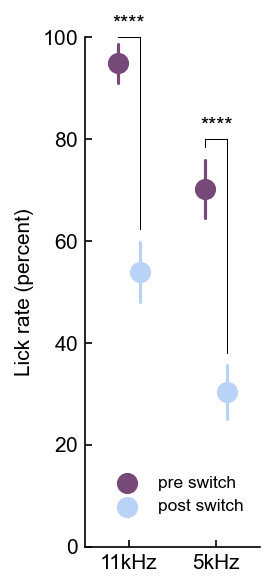

In [83]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

width = 0.125
offset = 0.125

# ax.plot([0-width,0+width],[np.mean(pre_lick_11khz),np.mean(post_lick_11khz)],lw=0.5,color=SWITCH_COLOR,zorder=-10)
# ax.plot([1-width,1+width],[np.mean(pre_lick_5khz),np.mean(post_lick_5khz)],lw=0.5,color=SWITCH_COLOR,zorder=-10)
# ax.plot([0-width,0+width],[np.mean(pre_lick_11khz),np.mean(post_lick_11khz)],lw=0.5,color=GOOD_GREY,zorder=-10)
# ax.plot([1-width,1+width],[np.mean(pre_lick_5khz),np.mean(post_lick_5khz)],lw=0.5,color=GOOD_GREY,zorder=-10)

# ax.scatter([0-width],np.mean(pre_lick_11khz),lw=0.5,zorder=1,color=PHASE_COLORS[2],s=10)
# ax.scatter([1-width],np.mean(pre_lick_5khz),lw=0.5,zorder=1,color=PHASE_COLORS[2],s=10)

# ax.scatter([0+width],np.mean(post_lick_11khz),lw=0.5,zorder=1,color=PHASE_COLORS[3],s=10)
# ax.scatter([1+width],np.mean(post_lick_5khz),lw=0.5,zorder=1,color=PHASE_COLORS[3],s=10)

colmaxes_pre = [np.nan,np.nan]
for idx,column in enumerate([pre_lick_11khz,pre_lick_5khz]):
    eye_color = PHASE_COLORS[2]
    border_color=eye_color
    summary_size=75
    summary_width=1.5
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes_pre[idx] = Q3
    
    ax.scatter([idx-offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx-offset, idx-offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
colmaxes_post = [np.nan,np.nan]
for idx,column in enumerate([post_lick_11khz,post_lick_5khz]):
    eye_color = PHASE_COLORS[3]
    border_color=eye_color
    summary_size=75
    summary_width=1.5
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes_post[idx] = Q3
    
    ax.scatter([idx+offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset, idx+offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.scatter([],[],s=summary_size,lw=summary_width,fc=PHASE_COLORS[2],ec=PHASE_COLORS[2],label='pre switch')
ax.scatter([],[],s=summary_size,lw=summary_width,fc=PHASE_COLORS[3],ec=PHASE_COLORS[3],label='post switch')
ax.legend(frameon=False,loc=(0.1,0.05))
    
ax.set_xlim([-0.5,1.5])
ax.set_xticks([0,1])
ax.set_xticklabels(['11kHz','5kHz'])

ax.set_ylim([0,100])

statsbar(ax,100,[0-offset,0+offset],stemheights=[colmaxes_pre[0],colmaxes_post[0]],text='****',lw=0.5)
statsbar(ax,80,[1-offset,1+offset],stemheights=[colmaxes_pre[1],colmaxes_post[1]],text='****',lw=0.5)

ax.set_ylabel('Lick rate (percent)')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Lick rate pre-post V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
fig.savefig(os.path.join('D:\\\\Figures','Switch Figures','Lick rate pre-post V'+str(current_version)+'.png'),transparent=False,facecolor="white", bbox_inches='tight')

In [54]:
mannwhitneyu(pre_lick_11khz,post_lick_11khz)

MannwhitneyuResult(statistic=296.0, pvalue=1.5163113197838256e-05)

In [55]:
mannwhitneyu(pre_lick_5khz,post_lick_5khz)

MannwhitneyuResult(statistic=285.0, pvalue=0.0001063061735187313)

# Comparing pre and post firing rates at different timescales

In [10]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task not in ['switch']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in np.concatenate((dualanimalnames,['DS_15','DS_16'])):
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 592/592 [00:02<00:00, 211.94it/s]
